In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import math

#from causalimpact import CausalImpact

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

#import tensorflow as tf
#import tensorflow_probability as tfp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# SparkSession
spark = SparkSession.builder.getOrCreate()

### Functions

In [ ]:
def get_corr(df: pd.DataFrame,
             ss_res: pd.DataFrame,
             var_1: str,
             var_2: str) -> None:
    '''
    Main focus: Compute correlation coefficient between two variables for pre- and post-treatment period, and percentage change between these two values
    Approach: Extracting relevant variable values, computing correlations and percentage changes, and updating the result DataFrame with the calculated correlation coeff
    '''
    # Iterate over each unique location_id values
    for location_id, group in df.groupby('location_id'):

        # Get treatment time
        treatment_time = group['intervention'].iloc[0]

        # Get var_1 values for both pre- and post-treatment period
        var1_pre, var1_post = group.loc[group['date'] < treatment_time, var_1], group.loc[group['date'] >= treatment_time, var_1]

        # Get var_2 values for both pre- and post-treatment period
        var2_pre, var2_post = group.loc[group['date'] < treatment_time, var_2], group.loc[group['date'] >= treatment_time, var_2]

        # Compute the correlation coefficient (Pearson) between two input variables
        corr_pre, corr_post = round(var1_pre.corr(var2_pre), 2), round(var1_post.corr(var2_post), 2)

        # Add correlation column into stat sig result dataframe
        ss_res.loc[ss_res['location_id'] == location_id, 'corr_pre'] = corr_pre
        ss_res.loc[ss_res['location_id'] == location_id, 'corr_post'] = corr_post

        # Add percentage change column computed between the correlation coeff in pre and post-treatment period
        percChange_corr = round(((corr_post - corr_pre)/ corr_pre) * 100, 2)
        ss_res.loc[ss_res['location_id'] == location_id, 'percChange_corr'] = percChange_corr

In [ ]:
def plot(df: pd.DataFrame,
         location_id: str,
         *args):
    '''
    Main focus: Plotting variable distributions
    Approach: Iterate through args and plot distributions
    '''
    # Create an instance of df
    df_temp = df[df['location_id'] == location_id]

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Iterate over each column in *args
    for col in args:

        # Reshape the values
        values = df_temp[col].values.reshape(-1, 1)

        # Fit and transform the values
        scaled = scaler.fit_transform(values)

        # Assign the scaled values back to the DataFrame
        df_temp[f'{col}_scaled'] = scaled

    # Plotting
    fig, ax1 = plt.subplots(figsize=(20, 5))

    # Plot each scaled column on the first y-axis
    for col in args:
        ax1.plot(df_temp['date'], df_temp[f'{col}_scaled'], label=col)

    # Dotted line at intervention time
    ax1.axvline(df_temp['intervention'].iloc[0], c='k', ls='--')

    # Set labels and title for the first y-axis
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')

    plt.show()

In [ ]:
def regression_inference_analysis(data: pd.DataFrame,
                                  location_id_group: list,
                                  formula: str) -> pd.DataFrame:
    '''
    Main focus: Conduct regression analysis on temperature and energy data for each location, comparing pre and post-treatment periods.
    Approach: Fit separate linear regression models for each location's pre and post-treatment periods, extracting intercepts, betas, and percentage changes for further analysis
    '''
    # Create an empty DataFrame to store all statistical metrics for all location_id
    results_df = pd.DataFrame()

    # Define inner function to apply OLS regression and get statistical metrics
    def process_location(location_id: str,
                         group: pd.DataFrame) -> pd.DataFrame:

        # Get treatment time
        treatment_time = group['intervention'].iloc[0]

        # Get pre and post treatment values
        pre_treatment, post_treatment = group.loc[group['date'] < treatment_time, :], group.loc[group['date'] >= treatment_time, :]

        # Define and fit two linear regression model for pre and post treatment period
        lm1 = smf.ols(formula=formula, data=pre_treatment).fit()
        lm2 = smf.ols(formula=formula, data=post_treatment).fit()

        # Get coefficient values
        alpha_pre, beta1_pre = lm1.params
        alpha_post, beta1_post = lm2.params

        # Get Standard Errors
        se_alpha_pre, se_beta1_pre = lm1.bse
        se_alpha_post, se_beta1_post = lm2.bse

        # Get p-values
        p_alpha_pre, p_beta1_pre = lm1.pvalues
        p_alpha_post, p_beta1_post = lm2.pvalues

        # Get Z score for z test
        z_score = (beta1_pre - beta1_post) / math.sqrt(se_beta1_pre**2 + se_beta1_post**2)

        # Create statistical metrics dataframe
        results = pd.DataFrame([{
            'location_id': location_id,
            'intercept_pre': round(alpha_pre, 0),
            'intercept_post': round(alpha_post,0),
            'interceptChange': round(((alpha_post - alpha_pre)/ abs(alpha_pre)) * 100, 2),
            'betas_pre': round(beta1_pre,0),
            'betas_post': round(beta1_post,0),
            'betasChange': round(((beta1_post - beta1_pre)/ abs(beta1_pre)) * 100, 2),
            'SE_intercept_pre': round(se_alpha_pre, 0),
            'SE_intercept_post': round(se_alpha_post, 0),
            'SE_betas_pre': round(se_beta1_pre, 0),
            'SE_betas_post': round(se_beta1_post, 0),
            'pvalue_intercept_pre': round(p_alpha_pre, 0),
            'pvalue_intercept_post': round(p_alpha_post, 0),
            'pvalue_betas_pre': round(p_beta1_pre, 0),
            'pvalue_betas_post': round(p_beta1_post, 0),
            'Z_score': round(z_score, 2)
        }])

        # Return statistical metrics for current location
        return results

    # Get specified group of data given IDs
    df = data[data['location_id'].isin(location_id_group)]

    # Parallelize the processing of each location
    processed_results = Parallel(n_jobs=-1)(
        delayed(process_location)(location_id, group)
        for location_id, group in df.groupby('location_id')
    )

    # Concatenate results from parallel processing
    results_df = pd.concat(processed_results, ignore_index=True)

    # Return the statistical metrics for each locaion_id
    return results_df

### Inference

Based on the results obtained with the *Bayesian Structural Time Series* (BSTS), we chose to delve deeper the *tfcausalimpact Hamiltonian Monte Carlo* (hmc). The reason for this choice is related to its more consistent and accurate results, although at the expense of longer computational time.

**Inference analysis steps**:
1. Obtain the best model results for statistically significant locations → BSTS tfcausalimpact hmc (12 months pre- and post-treatment period)
2. (SKIP) Eliminate extreme positive and negative relative effect values (→ greater or lower than 50% ) + provide a brief analysis on these type of locations (why do they show such extreme values?)
3. Calculate correlations between energy consumption and outdoor temperature over both pre- and post-treatment period (*). Then, compare the resulting coefficients with the goal of detecting locations that have undergone changes in heating systems, translated in structural upward or downward shifts. Before drawing conclusions double check the location in home profile --> discard locations that show anomaly and pattern
4. Identify and retrieve only those locations with no changes
5. Separate locations with positive relative effects from those with negative relative effects
6. Regression as inference analysis on positive and negative group
7. Draw conclusions based on the differences observed between these two groups

(*) We would expect *strong negative correlations* for those locations with electrical heating systems and therefore locations that exhibit *negligible* or *positive correlation* probably do not use electricity for heating in any meaningful way, or use it in a way difficult to detect

#### Step 1 - Get the best model results for statistically significant locations

In [ ]:
# Load jersey_data and jersey_results_BSTS_3
jersey = 'eliqdatalake.playground.jersey_data'
results_BSTS_hmc = 'eliqdatalake.playground.jersey_results_BSTS_3'
hp = 'eliqdatalake.home_profile.silver_home_profile'

query_jersey = f"SELECT * FROM {jersey}"
query_BSTS_hmc = f"SELECT * FROM {results_BSTS_hmc}"
query_home_profile = f"SELECT * FROM {hp}"

data = spark.sql(query_jersey).toPandas().sort_values(['location_id', 'date']).reset_index(drop=True)
results_BSTS_hmc = spark.sql(query_BSTS_hmc).toPandas().sort_values(['location_id']).reset_index(drop=True)
home_profile = spark.sql(query_home_profile).toPandas().sort_values(['client_id','location_id']).reset_index(drop=True)

In [ ]:
# TODO: Go back to preprocessing phase and add condition to check the presence of zero-values --> ex 1840990 ==> DONE in handling_missing()
d = [loc_id for loc_id, group in data.groupby('location_id') if (group['energy']==0).sum()/len(group) >= 0.2]
for location_id in d:
    data.drop(data.query(f'location_id=={location_id}').index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
# Drop differentiated columns since BSTS can handle structural changes in the data
data.drop(['energy_diff', 'temp_diff', 'cloudcover_diff', 'humidity_diff', 'precip_diff', 'windspeed_diff', 'brightness_s2s_diff', 'energyprice', 'energyprice_percChange', 'energyprice_change', 'energyprice_diff', 'energyprice_percChange_diff', 'energyprice_change_diff'], inplace=True, axis=1)

In [ ]:
# Get statistically significant (p-value <= 5%) locations
results_stat_sig = results_BSTS_hmc.groupby('location_id').filter(lambda group: (group['Posterior_tail_area_probability_p'] <= 0.05).any())['location_id'].unique().tolist()
stat_sig_location = results_BSTS_hmc[results_BSTS_hmc['location_id'].isin(results_stat_sig)].copy().reset_index(drop=True)

[(-100.0, 100.0)]

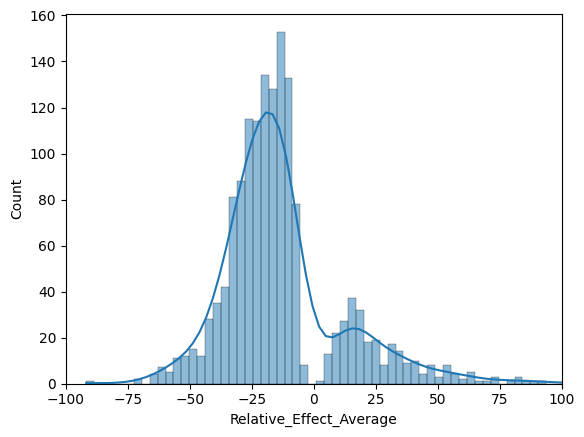

In [ ]:
# Histogram average relative effects
plot = sns.histplot(data=stat_sig_location, x='Relative_Effect_Average', kde=True)
plot.set(xlim=(-100,100))

In [ ]:
# Get location_id for extreme positive and negative results --> 94 locations that exhibits extreme values in relative effect
extreme_location = stat_sig_location[(stat_sig_location['Relative_Effect_Average'] < -50) | (stat_sig_location['Relative_Effect_Average'] > 50)].reset_index(drop=True)

#### Step 2 (SKIP) - Get rid of extreme negative and positive results + Brief analysis

#### Step 3 - Get correlation coeff between energy and (outdoor) temperature over pre- and post-treatment period

In [ ]:
# Get correlation coefficient for energy and temperature variables in pre- and post-treatment period
get_corr(data, stat_sig_location, 'energy', 'temp')

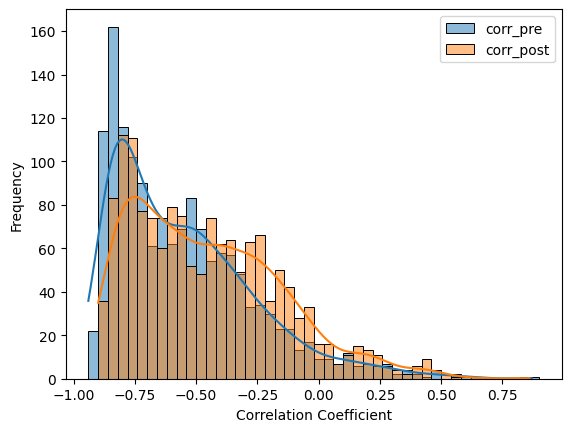

In [ ]:
# Histogram correlation coeff distribution
plot1 = sns.histplot(data=stat_sig_location, x='corr_pre', kde=True, binwidth=0.04, label='corr_pre')
plot2 = sns.histplot(data=stat_sig_location, x='corr_post', kde=True, binwidth=0.04, label='corr_post')
plt.legend()
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()
#plot.set(xlim=(-1000,1000))

**Explanation of location with and without change in correlation coefficient**:

The resulting correlation values for pre- and post-treatment period can be classied as follows:

|                   | **Negative corr Pre** | Zero/Positive corr Pre |
|-------------------|------------------------|-------------------------|
| **Negative corr Post** | No change in fuel (elec in both) | Change in fuel (no elec in pre to elec in post) |
| **Zero/Positive corr Post** | Change in fuel (elec in pre to no elec in post) | No change in fuel (no elec in both) |

#### Step 4 - Get locations with no changes (and with changes)

**Goal**:
* The variable *location_nochange* includes locations where no changes in fuel occurred (top-left corner of the matrix). This implies that, throughout the entire analysis period, these locations consistently utilized electricity as their primary fuel source. It's crucial to highlight that we specifically focus on strong negative correlation values for both pre- and post-treatment period, hence considering coefficients lower than -0.40
* Conversely, the variable *location_change* includes all other locations in the matrix. This encompasses locations that experienced a change in fuel during the analysis period, as well as locations where no change was observed but are still included because they never relied on electricity as a fuel source. Essentially, we account for locations that exhibit strong positive correlation values or values close to zero

In summary, we discard all those locations that had switched fuels or no elec usage over both periods (labeled as *location_change*). Further analysis are performed on those locations without any change in fuel (labeled as *location_nochange*)

In [ ]:
# Get location_nochange --> locations with elec heating systems exhibit a strong negative corr both pre and post treatment
location_nochange = stat_sig_location.query('corr_pre <= -0.4 and corr_post <= -0.4').reset_index(drop=True)

In [ ]:
# Get location_change --> locations with changes in heating systems exhibit a zero/positive corr for pre and post treatment (leftjoin exclusive)
location_change = stat_sig_location.merge(location_nochange[['location_id']], on='location_id', how='left', indicator=True)
location_change = location_change[location_change['_merge'] == 'left_only'].drop(columns=['_merge']).reset_index(drop=True)

#### Step 5 - Separate locations (no change) with positive relative effects from those with negative relative effects

In [ ]:
# Get positive and negative effect locations
pos = location_nochange[location_nochange['Relative_Effect_Average'] > 0].reset_index(drop=True)
neg = location_nochange[location_nochange['Relative_Effect_Average'] <= 0].reset_index(drop=True)

[(-100.0, 100.0)]

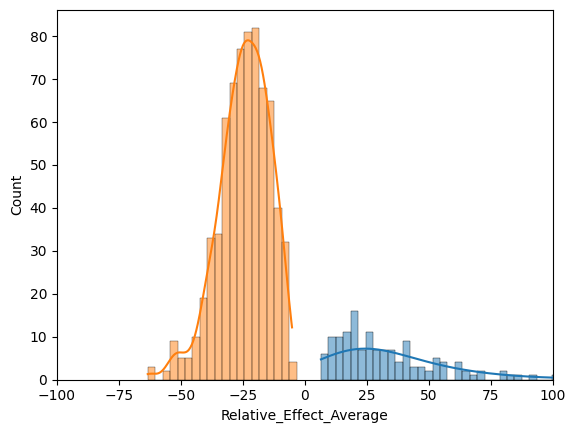

In [ ]:
# Histogram negative and positive average relative effects
plot = sns.histplot(data=pos, x='Relative_Effect_Average', kde=True, binwidth=3)
plot = sns.histplot(data=neg, x='Relative_Effect_Average', kde=True, binwidth=3)
plot.set(xlim=(-100, 100))

In [ ]:
# Analysis positive (avg) relative effects
pos.loc[:, ~pos.columns.isin(['location_id', 'corr_pre', 'corr_post', 'percChange_corr'])].describe()

,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect
count,144.000000,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,25618.279583,9.376290e+06,19009.588056,2499.214375,6.957509e+06,9.147124e+05,6608.691319,2499.214375,2.418781e+06,9.147124e+05,39.201111,14.940556,39.201111,14.940556,0.013333,98.593333
std,13734.221347,5.026725e+06,10433.013806,2421.705978,3.818483e+06,8.863444e+05,5805.249042,2421.705978,2.124721e+06,8.863444e+05,40.819223,18.120928,40.819223,18.120928,0.015329,1.542593
min,4558.060000,1.668250e+06,2927.230000,174.620000,1.071365e+06,6.391175e+04,316.670000,174.620000,1.159008e+05,6.391175e+04,6.470000,2.610000,6.470000,2.610000,0.000000,94.610000
25%,16260.030000,5.951169e+06,10923.830000,876.502500,3.998121e+06,3.207987e+05,2823.590000,876.502500,1.033434e+06,3.207987e+05,18.172500,5.910000,18.172500,5.910000,0.000000,97.600000
50%,22666.490000,8.295935e+06,16888.280000,1606.485000,6.181111e+06,5.879738e+05,4938.915000,1606.485000,1.807644e+06,5.879738e+05,27.625000,9.295000,27.625000,9.295000,0.010000,99.200000
75%,31450.237500,1.151079e+07,23420.615000,3521.700000,8.571944e+06,1.288942e+06,7903.692500,3521.700000,2.892752e+06,1.288942e+06,45.595000,16.985000,45.595000,16.985000,0.020000,100.000000
max,71849.640000,2.629697e+07,55966.930000,12300.780000,2.048390e+07,4.502084e+06,40131.720000,12300.780000,1.468821e+07,4.502084e+06,360.710000,165.730000,360.710000,165.730000,0.050000,100.000000


In [ ]:
# Compute confidence interval 95% values for positive (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Avg) {col}', pos[col].apply(pd.Series).mean().astype(int).tolist() )

(Avg) 95_CI_Average [14049, 23846]
(Avg) 95_CI_Cumulative [5142187, 8727795]
(Avg) 95_CI_Absolute_Effect_Average [1771, 11568]
(Avg) 95_CI_Absolute_Effect_Cumulative [648495, 4234102]
(Avg) 95_CI_Relative_Effect_Average [10, 68]
(Avg) 95_CI_Relative_Effect_Cumulative [10, 68]


In [ ]:
# Compute confidence interval 95% values for positive (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Median) {col}', pos[col].apply(pd.Series).median().astype(int).tolist() )

(Median) 95_CI_Average [12762, 20805]
(Median) 95_CI_Cumulative [4671150, 7614685]
(Median) 95_CI_Absolute_Effect_Average [696, 8112]
(Median) 95_CI_Absolute_Effect_Cumulative [255004, 2969080]
(Median) 95_CI_Relative_Effect_Average [4, 49]
(Median) 95_CI_Relative_Effect_Cumulative [4, 49]


In [ ]:
# Compute the median values for positive (avg) relative effects
columns = ['Actual_Average',
           'Prediction_Average',
           'Absolute_Effect_Average',
           'Relative_Effect_Average',
           'Posterior_tail_area_probability_p']
for col in columns:
    print(f'Median for {col}', pos[col].sort_values().median())

Median for Actual_Average 22666.489999999998
Median for Prediction_Average 16888.28
Median for Absolute_Effect_Average 4938.915
Median for Relative_Effect_Average 27.625
Median for Posterior_tail_area_probability_p 0.01


In [ ]:
# Analysis negative (avg) relative effects
neg.loc[:, ~neg.columns.isin(['location_id', 'corr_pre', 'corr_post', 'percChange_corr'])].describe()

,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect
count,699.000000,6.990000e+02,699.000000,699.000000,6.990000e+02,6.990000e+02,699.000000,699.000000,6.990000e+02,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,24213.051373,8.861977e+06,32504.933047,3515.260186,1.189681e+07,1.286585e+06,-8291.881903,3515.260186,-3.034829e+06,1.286585e+06,-24.403662,10.185937,-24.403662,10.185937,0.015966,98.321087
std,12798.442337,4.684230e+06,17143.774304,2763.134322,6.274621e+06,1.011307e+06,6102.354540,2763.134322,2.233462e+06,1.011307e+06,10.249086,4.706662,10.249086,4.706662,0.016482,1.645598
min,3540.040000,1.295655e+06,4107.990000,88.090000,1.503525e+06,3.224123e+04,-41238.420000,88.090000,-1.509326e+07,3.224123e+04,-63.370000,2.140000,-63.370000,2.140000,0.000000,94.510000
25%,15054.660000,5.510006e+06,20395.320000,1541.280000,7.464687e+06,5.641080e+05,-10914.465000,1541.280000,-3.994696e+06,5.641080e+05,-30.805000,6.845000,-30.805000,6.845000,0.000000,97.100000
50%,21766.610000,7.966578e+06,29407.790000,2764.820000,1.076325e+07,1.011923e+06,-6986.700000,2764.820000,-2.557133e+06,1.011923e+06,-23.480000,9.220000,-23.480000,9.220000,0.010000,99.000000
75%,29822.515000,1.091504e+07,41123.355000,4674.670000,1.505115e+07,1.710929e+06,-3829.710000,4674.670000,-1.401673e+06,1.710929e+06,-16.995000,12.480000,-16.995000,12.480000,0.030000,99.700000
max,88257.280000,3.230217e+07,119646.230000,19953.630000,4.379052e+07,7.303029e+06,-567.950000,19953.630000,-2.078699e+05,7.303029e+06,-5.190000,34.230000,-5.190000,34.230000,0.050000,100.000000


In [ ]:
# Compute confidence interval 95% values for negative (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Avg) {col}', neg[col].apply(pd.Series).mean().astype(int).tolist() )

(Avg) 95_CI_Average [25686, 39465]
(Avg) 95_CI_Cumulative [9401125, 14444447]
(Avg) 95_CI_Absolute_Effect_Average [-15252, -1473]
(Avg) 95_CI_Absolute_Effect_Cumulative [-5582471, -539148]
(Avg) 95_CI_Relative_Effect_Average [-44, -4]
(Avg) 95_CI_Relative_Effect_Cumulative [-44, -4]


In [ ]:
# Compute confidence interval 95% values for negative (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Median) {col}', neg[col].apply(pd.Series).median().astype(int).tolist() )

(Median) 95_CI_Average [22966, 35237]
(Median) 95_CI_Cumulative [8405765, 12897042]
(Median) 95_CI_Absolute_Effect_Average [-12835, -811]
(Median) 95_CI_Absolute_Effect_Cumulative [-4697955, -296853]
(Median) 95_CI_Relative_Effect_Average [-42, -3]
(Median) 95_CI_Relative_Effect_Cumulative [-42, -3]


In [ ]:
# Compute the median values for negative (avg) relative effects
columns = ['Actual_Average',
           'Prediction_Average',
           'Absolute_Effect_Average',
           'Relative_Effect_Average',
           'Posterior_tail_area_probability_p']
for col in columns:
    print(f'Median for {col}', neg[col].sort_values().median())

Median for Actual_Average 21766.61
Median for Prediction_Average 29407.79
Median for Absolute_Effect_Average -6986.7
Median for Relative_Effect_Average -23.48
Median for Posterior_tail_area_probability_p 0.01


#### Step 6 - Regression analysis

**Goal**: Regression as inference analysis on different groups.

**Why?** The interesting questions having two different groups (positive and negative relative effect) are the following: “why do we have them?”, “what’s driving their difference?”. \ In the previous analysis, we discarded all those locations that had switched fuels. So this is a difficult question to answer because positive group might be due to other various reasons not easy to detect, for instance, a family just had a baby and started heating a bit more the house, or a new tenant doesn’t care too much about keeping heating too high since it pays a fixed fee for electricity to its landlord, or maybe just more people started living in the house. Viceversa, we can say about the negative group

**How?** To identify potential reasons for the divergence, we conduct a regression analysis on the temperature (as regressor/independent variable) and energy data (as dependent variable), one for each period. We compare the intercepts for the pre and post-treatment periods, as well as their beta values.

**Z-test**: \
Goal: TODO\
Z-test: The z-score is computed as $$ Z = \frac{{\beta_1 - \beta_2}}{{\sqrt{{SE_{\beta_1}^2 + SE_{\beta_2}^2}}}} $$
where Beta 1 is beta of pre treatment period, Beta 2 is beta of post treatment period, SE Beta 1 is Standard Error of Beta 1 and SE Beta 2 is Standard Error of Beta 2.\
Null Hypothesis (No significant change in betas)
$$ H_0 : \beta_1 = \beta_2 $$
Alternative Hypothesis (Significant change in betas)
$$ H_1 : \beta_1 \neq \beta_2 $$
Procedure: Compare the abs value of Z score with the critical value for a two-tailed test at the 5% level of significance (i.e., if type of test is Two-tailed then critical value is +-1.960). If abs value of Z score is greater than the critical Z value (1.960), then reject the null hypothesis.


To investigate each effect, thereby understanding if the policy intervention:
1. has no significant change, i.e., both betas are not statistically significant --> it suggests that the intervention did not have a significant impact on the relationship between temp and energy
2. has only an immediate effect (shift in baseline energy consumption), i.e., significant change only in intercepts (alphas) --> it suggests a shift in baseline energy consumption not explained by temperature, potentially due to the intervention or other external factors
3. has only a sustained, long term effect  (change in sensitivity), i.e., siggnificant change only in slopes (betas) --> it suggests a change in the sensitivity of energy consumption to temperature - this could indicate a shift in energy usage patterns post-intervention
4. has both an immediate and a sustained effect, i.e., significant change in both intercept and slopes

##### Regression analysis (positive group)

In [ ]:
# Run regression analysis on positive group
pos_id = pos['location_id'].tolist()
results_pos_group = regression_inference_analysis(data=data,
                                                  location_id_group=pos_id,
                                                  formula='energy ~ temp')

In [ ]:
# Double check on Home Profile --> not 100% reliable
# Query for Jersey: client_id == 6788630634
homeprofile_pos = home_profile.query(f'client_id == 6788630634 and location_id == {pos_id}')

# Discard locations that show anomalies --> for each effect, analysis performed by looking at the energy distribution discarding those locations with anomaly spikes
anomaly_pos = [1818582, 1818973, 1661449, 1420099, 1818827, 2645378, 1420099, 1818827, 2645378]

# Discard locations that show patterns --> for each effect, analysis performed by looking at the energy distribution discarding those locations with patterns not controllable by Eliq
pattern_pos = [1661645, 1817703, 1810491, 1661088, 1662084, 1660366, 1660610, 1803208, 1815646, 1818561, 2148332, 1814587]

# Get rid of them
discarded_loc_pos = anomaly_pos + pattern_pos
for location_id in discarded_loc_pos:
    results_pos_group.drop(results_pos_group.query(f'location_id=={location_id}').index, inplace=True)
    pos.drop(pos.query(f'location_id=={location_id}').index, inplace=True)
results_pos_group.reset_index(drop=True, inplace=True)
pos.reset_index(drop=True,inplace=True)
results_pos_group

,location_id,intercept_pre,intercept_post,interceptChange,betas_pre,betas_post,betasChange,SE_intercept_pre,SE_intercept_post,SE_betas_pre,SE_betas_post,pvalue_intercept_pre,pvalue_intercept_post,pvalue_betas_pre,pvalue_betas_post,Z_score
0,1420131,33871.0,42524.0,25.55,-672.0,-1017.0,-51.27,802.0,1372.0,62.0,100.0,0.0,0.0,0.0,0.0,2.92
1,1420186,68212.0,69415.0,1.76,-2379.0,-2398.0,-0.80,1430.0,1800.0,109.0,142.0,0.0,0.0,0.0,0.0,0.11
2,1420631,24277.0,33666.0,38.67,-495.0,-1106.0,-123.28,588.0,706.0,47.0,51.0,0.0,0.0,0.0,0.0,8.81
3,1660323,20350.0,27975.0,37.47,-767.0,-1225.0,-59.59,428.0,595.0,34.0,46.0,0.0,0.0,0.0,0.0,8.07
4,1660352,16548.0,17979.0,8.64,-617.0,-720.0,-16.66,398.0,415.0,29.0,31.0,0.0,0.0,0.0,0.0,2.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2394007,54952.0,108874.0,98.13,-1618.0,-5033.0,-211.11,974.0,4295.0,75.0,336.0,0.0,0.0,0.0,0.0,9.91
122,2572809,34737.0,31099.0,-10.47,-1181.0,-665.0,43.69,760.0,838.0,56.0,62.0,0.0,0.0,0.0,0.0,-6.17
123,2607601,81136.0,79232.0,-2.35,-3360.0,-3393.0,-0.98,1499.0,1724.0,120.0,127.0,0.0,0.0,0.0,0.0,0.19
124,2734826,86366.0,87441.0,1.25,-4037.0,-4191.0,-3.80,1810.0,1511.0,132.0,113.0,0.0,0.0,0.0,0.0,0.88


In [ ]:
# Get locations with different effects within positive group
loc_nosignchange_pos = results_pos_group.query('abs(Z_score)<1.960')['location_id'].tolist()
loc_immediate_effect_pos = results_pos_group.query('((abs(interceptChange) > 0) and (abs(betasChange) == 0)) and (abs(Z_score)>=1.960)')['location_id'].tolist()
loc_sustained_effect_pos = results_pos_group.query('((abs(interceptChange) == 0) and (abs(betasChange) > 0)) and (abs(Z_score)>=1.960)')['location_id'].tolist()
loc_immediate_sustained_effect_pos = results_pos_group.query('((abs(interceptChange) > 0) and (abs(betasChange) > 0)) and (abs(Z_score)>=1.960)')['location_id'].tolist()

print('Total number of locations with positive relative effect is:', len(results_pos_group))
print('Number of locations with no significant change is:',len(loc_nosignchange_pos))
print('Number of locations with immediate effect (intercept change only) is:',len(loc_immediate_effect_pos))
print('Number of locations with sustained effect (betas change only) is:',len(loc_sustained_effect_pos))
print('Number of locations with both immediate and sustained effect (intercept and betas change) is:',len(loc_immediate_sustained_effect_pos))

Total number of locations with positive relative effect is: 126
Number of locations with no significant change is: 36
Number of locations with immediate effect (intercept change only) is: 0
Number of locations with sustained effect (betas change only) is: 0
Number of locations with both immediate and sustained effect (intercept and betas change) is: 90


Those (all) locations that show both an immediate and a sustained effect can be further divided into 4 categories:
* Positive change in intercept and positive change in betas
* Positive change in intercept and negative change in betas
* Negative change in intercept and positive change in betas
* Negative change in intercept and negative change in betas

In [ ]:
# Since we have only locations registering both immediate and sustained effect, we further divide them depending the sign of both interceptChange and betasChange

# Get rid of those locations that exhibit no significant change
results_pos_group = results_pos_group[~results_pos_group['location_id'].isin(loc_nosignchange_pos)]
pos = pos[~pos['location_id'].isin(loc_nosignchange_pos)]

# Get locations with positive change in both intercept and betas
posinterc_posbetas_pos = results_pos_group.query('(interceptChange > 0) and (betasChange > 0)')['location_id'].tolist()

# Get locations with positive change in intercept but negative change in betas
posinterc_negbetas_pos = results_pos_group.query('(interceptChange > 0) and (betasChange <= 0)')['location_id'].tolist()

# Get locations with positive change in betas but negative change in intercept
neginterc_posbetas_pos = results_pos_group.query('(interceptChange <= 0) and (betasChange > 0)')['location_id'].tolist()

# Get locations with negative change in both intercept and betas
neginterc_negbetas_pos = results_pos_group.query('(interceptChange <= 0) and (betasChange <= 0)')['location_id'].tolist()

print('Total number of locations with positive relative effect and both immediate and sustained effect is:', len(loc_immediate_sustained_effect_pos))
print('Number of locations with positive change in both intercept and betas is:',len(posinterc_posbetas_pos))
print('Number of locations with positive change in intercept but negative change in betas is:',len(posinterc_negbetas_pos))
print('Number of locations with positive change in betas but negative change in intercept is:',len(neginterc_posbetas_pos))
print('Number of locations with negative change in both intercept and betas is:',len(neginterc_negbetas_pos))

Total number of locations with positive relative effect and both immediate and sustained effect is: 90
Number of locations with positive change in both intercept and betas is: 3
Number of locations with positive change in intercept but negative change in betas is: 70
Number of locations with positive change in betas but negative change in intercept is: 17
Number of locations with negative change in both intercept and betas is: 0


In [ ]:
# Summary of statistics for all positive locations
loc_id_res_pos = pos['location_id'].unique().tolist()
stat_sig_location.query(f'location_id=={loc_id_res_pos}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,9.000000e+01,90.000000,9.000000e+01,90.000000,90.000000,9.000000e+01,9.000000e+01,90.000000,90.000000,9.000000e+01,9.000000e+01,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,1.852229e+06,26296.491778,9.624516e+06,20249.660667,2309.602889,7.411376e+06,8.453145e+05,6046.831111,2309.602889,2.213140e+06,8.453145e+05,33.636333,12.391889,33.636333,12.391889,0.011667,98.763667,-0.647111,-0.668222,6.033556
std,1.904721e+05,13941.129823,5.102454e+06,11392.293072,2291.170739,4.169580e+06,8.385685e+05,4194.621446,2291.170739,1.535231e+06,8.385685e+05,26.226348,12.490168,26.226348,12.490168,0.014934,1.494873,0.147962,0.117823,19.488870
min,1.420131e+06,7022.580000,2.570266e+06,5937.430000,374.750000,2.173099e+06,1.371583e+05,883.600000,374.750000,3.233978e+05,1.371583e+05,6.470000,2.610000,6.470000,2.610000,0.000000,94.610000,-0.900000,-0.860000,-33.780000
25%,1.806517e+06,16375.345000,5.993375e+06,11853.017500,854.130000,4.338204e+06,3.126110e+05,3052.887500,854.130000,1.117356e+06,3.126110e+05,17.065000,5.405000,17.065000,5.405000,0.000000,97.725000,-0.767500,-0.770000,-5.515000
50%,1.812498e+06,22785.445000,8.339472e+06,17487.480000,1447.105000,6.400418e+06,5.296402e+05,4901.520000,1447.105000,1.793954e+06,5.296402e+05,27.800000,8.255000,27.800000,8.255000,0.000000,99.500000,-0.635000,-0.680000,5.180000
75%,1.838504e+06,32050.292500,1.173041e+07,24548.660000,2397.620000,8.984810e+06,8.775295e+05,7954.360000,2397.620000,2.911296e+06,8.775295e+05,41.145000,14.657500,41.145000,14.657500,0.020000,100.000000,-0.502500,-0.582500,15.825000
max,2.572809e+06,67138.800000,2.457280e+07,55966.930000,10746.670000,2.048390e+07,3.933281e+06,19314.590000,10746.670000,7.069138e+06,3.933281e+06,194.350000,80.160000,194.350000,80.160000,0.050000,100.000000,-0.400000,-0.400000,70.450000


In [ ]:
# Compute confidence interval 95% values for positive (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Avg) {col}', pos[col].apply(pd.Series).mean().astype(int).tolist() )

(Avg) 95_CI_Average [15658, 24711]
(Avg) 95_CI_Cumulative [5730899, 9044472]
(Avg) 95_CI_Absolute_Effect_Average [1584, 10638]
(Avg) 95_CI_Absolute_Effect_Cumulative [580043, 3893616]
(Avg) 95_CI_Relative_Effect_Average [9, 58]
(Avg) 95_CI_Relative_Effect_Cumulative [9, 58]


In [ ]:
# Compute confidence interval 95% values for positive (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Median) {col}', pos[col].apply(pd.Series).median().astype(int).tolist() )

(Median) 95_CI_Average [13974, 20906]
(Median) 95_CI_Cumulative [5114822, 7651768]
(Median) 95_CI_Absolute_Effect_Average [949, 7858]
(Median) 95_CI_Absolute_Effect_Cumulative [347409, 2876361]
(Median) 95_CI_Relative_Effect_Average [4, 44]
(Median) 95_CI_Relative_Effect_Cumulative [4, 44]


In [ ]:
# Compute the median values for positive (avg) relative effects
columns = ['Actual_Average',
           'Prediction_Average',
           'Absolute_Effect_Average',
           'Relative_Effect_Average',
           'Posterior_tail_area_probability_p']
for col in columns:
    print(f'Median for {col}', pos[col].sort_values().median())

Median for Actual_Average 22785.445
Median for Prediction_Average 17487.48
Median for Absolute_Effect_Average 4901.52
Median for Relative_Effect_Average 27.8
Median for Posterior_tail_area_probability_p 0.0


In [ ]:
# Summary of statistics for positive locations with positive change in intercept and positive change in betas
stat_sig_location.query(f'location_id=={posinterc_posbetas_pos}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,3.000000e+00,3.00000,3.000000e+00,3.000000,3.0000,3.000000e+00,3.000000,3.000000,3.0000,3.000000e+00,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000
mean,1.972853e+06,24516.99000,8.973218e+06,18447.110000,1589.9400,6.751642e+06,581918.316667,6069.883333,1589.9400,2.221576e+06,581918.316667,43.150000,11.443333,43.150000,11.443333,0.0,99.833333,-0.690000,-0.596667,-13.680000
std,2.295261e+05,8629.75564,3.158490e+06,10231.304622,381.4049,3.744657e+06,139594.090728,2388.876968,381.4049,8.743288e+05,139594.090728,27.778234,8.533208,27.778234,8.533208,0.0,0.208167,0.045826,0.073711,6.096089
min,1.839747e+06,15993.27000,5.853537e+06,9670.540000,1310.9000,3.539420e+06,479790.900000,3564.640000,1310.9000,1.304657e+06,479790.900000,12.010000,4.420000,12.010000,4.420000,0.0,99.600000,-0.730000,-0.680000,-18.570000
25%,1.840336e+06,20150.98000,7.375259e+06,12828.480000,1372.6400,4.695224e+06,502386.455000,4943.685000,1372.6400,1.809387e+06,502386.455000,32.035000,6.695000,32.035000,6.695000,0.0,99.750000,-0.715000,-0.625000,-17.095000
50%,1.840926e+06,24308.69000,8.896981e+06,15986.420000,1434.3800,5.851028e+06,524982.010000,6322.730000,1434.3800,2.314118e+06,524982.010000,52.060000,8.970000,52.060000,8.970000,0.0,99.900000,-0.700000,-0.570000,-15.620000
75%,2.039406e+06,28778.85000,1.053306e+07,22835.395000,1729.4600,8.357754e+06,632982.025000,7322.505000,1729.4600,2.680035e+06,632982.025000,58.720000,14.955000,58.720000,14.955000,0.0,99.950000,-0.670000,-0.555000,-11.235000
max,2.237886e+06,33249.01000,1.216914e+07,29684.370000,2024.5400,1.086448e+07,740982.040000,8322.280000,2024.5400,3.045953e+06,740982.040000,65.380000,20.940000,65.380000,20.940000,0.0,100.000000,-0.640000,-0.540000,-6.850000


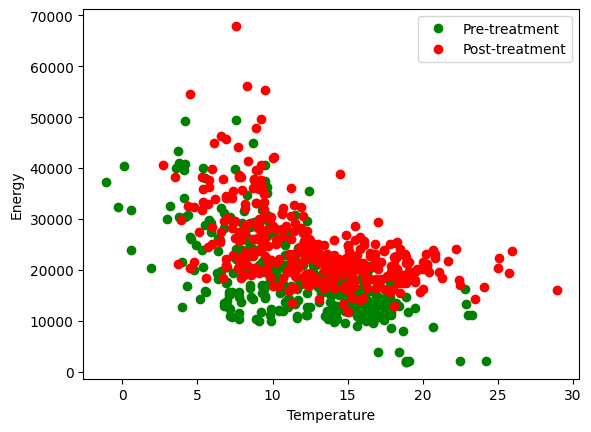

In [ ]:
# Example of positive (relative effect) locations with positive change in intercept and positive change in betas
plt.plot(data.query("(location_id==2237886) and (date < '2021-11-01')")['temp'], data.query("location_id==2237886  and (date < '2021-11-01') ")['energy'], 'o', color='green', label='Pre-treatment')
plt.plot(data.query("(location_id==2237886) and (date >= '2021-11-01')")['temp'], data.query("location_id==2237886  and (date >= '2021-11-01') ")['energy'], 'o', color='red', label='Post-treatment')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
# Summary of statistics for positive locations with positive change in intercept and negative change in betas
stat_sig_location.query(f'location_id=={posinterc_negbetas_pos}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,7.000000e+01,70.000000,7.000000e+01,70.000000,70.000000,7.000000e+01,7.000000e+01,70.000000,70.000000,7.000000e+01,7.000000e+01,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,1.820007e+06,24015.570143,8.789699e+06,18750.585714,1759.811286,6.862714e+06,6.440908e+05,5264.984143,1759.811286,1.926984e+06,6.440908e+05,31.747571,10.640143,31.747571,10.640143,0.009571,98.950429,-0.604143,-0.658429,11.243714
std,1.498407e+05,12089.628007,4.424804e+06,9978.141446,1888.640676,3.652000e+06,6.912424e+05,3909.033750,1888.640676,1.430706e+06,6.912424e+05,28.101793,12.902615,28.101793,12.902615,0.014787,1.493941,0.134934,0.116229,18.337108
min,1.420131e+06,7022.580000,2.570266e+06,5937.430000,374.750000,2.173099e+06,1.371583e+05,883.600000,374.750000,3.233978e+05,1.371583e+05,6.470000,2.610000,6.470000,2.610000,0.000000,94.610000,-0.890000,-0.850000,-23.210000
25%,1.806418e+06,15521.185000,5.680755e+06,11344.055000,795.822500,4.151924e+06,2.912705e+05,2246.040000,795.822500,8.220518e+05,2.912705e+05,16.077500,4.805000,16.077500,4.805000,0.000000,98.250000,-0.735000,-0.760000,-1.140000
50%,1.811466e+06,22161.285000,8.111030e+06,17215.405000,1050.410000,6.300839e+06,3.844503e+05,4370.215000,1050.410000,1.599498e+06,3.844503e+05,24.330000,6.865000,24.330000,6.865000,0.000000,99.750000,-0.565000,-0.660000,9.445000
75%,1.816711e+06,29053.557500,1.063360e+07,22692.352500,1930.032500,8.305401e+06,7.063913e+05,6584.377500,1930.032500,2.409882e+06,7.063913e+05,37.257500,10.617500,37.257500,10.617500,0.020000,100.000000,-0.490000,-0.572500,18.915000
max,2.394007e+06,59011.480000,2.159820e+07,51629.280000,10746.670000,1.889632e+07,3.933281e+06,18052.180000,10746.670000,6.607099e+06,3.933281e+06,194.350000,80.160000,194.350000,80.160000,0.050000,100.000000,-0.400000,-0.400000,70.450000


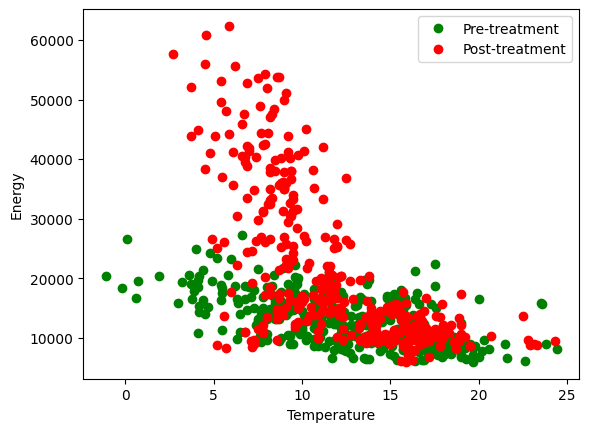

In [ ]:
# Example of positive (relative effect) locations with positive change in intercept and negative change in betas
plt.plot(data.query("(location_id==1807002) and (date < '2021-04-04')")['temp'], data.query("location_id==1807002  and (date < '2021-04-04') ")['energy'], 'o', color='green', label='Pre-treatment')
plt.plot(data.query("(location_id==1807002) and (date >= '2021-04-04')")['temp'], data.query("location_id==1807002  and (date >= '2021-04-04') ")['energy'], 'o', color='red', label='Post-treatment')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
# Summary of statistics for positive locations with negative change in intercept and positive change in betas
stat_sig_location.query(f'location_id=={neginterc_posbetas_pos}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,1.700000e+01,17.000000,1.700000e+01,17.000000,17.000000,1.700000e+01,1.700000e+01,17.000000,17.000000,1.700000e+01,1.700000e+01,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,1.963625e+06,36002.551765,1.317693e+07,26740.419412,4700.450000,9.786993e+06,1.720365e+06,9262.132941,4700.450000,3.389941e+06,1.720365e+06,39.734706,19.772353,39.734706,19.772353,0.022353,97.805882,-0.816471,-0.721176,-11.941176
std,2.791767e+05,17833.376363,6.527016e+06,14975.639667,2511.269122,5.481085e+06,9.191247e+05,4195.460082,2511.269122,1.535538e+06,9.191247e+05,15.869223,8.322758,15.869223,8.322758,0.011472,1.207513,0.064026,0.117998,11.094659
min,1.660926e+06,14450.840000,5.289007e+06,9611.590000,1870.890000,3.517841e+06,6.847462e+05,3892.490000,1870.890000,1.424650e+06,6.847462e+05,15.480000,6.670000,15.480000,6.670000,0.000000,95.600000,-0.900000,-0.860000,-33.780000
25%,1.806478e+06,22689.280000,8.304276e+06,15409.850000,2402.940000,5.640004e+06,8.794769e+05,6358.600000,2402.940000,2.327246e+06,8.794769e+05,30.360000,14.590000,30.360000,14.590000,0.020000,97.400000,-0.880000,-0.810000,-16.470000
50%,1.816031e+06,31042.770000,1.136166e+07,22071.490000,4422.970000,8.078166e+06,1.618806e+06,8666.150000,4422.970000,3.171810e+06,1.618806e+06,39.840000,20.040000,39.840000,20.040000,0.020000,97.700000,-0.830000,-0.740000,-7.500000
75%,2.217636e+06,52823.360000,1.933335e+07,39349.240000,5498.270000,1.440182e+07,2.012365e+06,10728.440000,5498.270000,3.926608e+06,2.012365e+06,46.670000,22.750000,46.670000,22.750000,0.030000,98.300000,-0.790000,-0.680000,-3.750000
max,2.572809e+06,67138.800000,2.457280e+07,55966.930000,10209.300000,2.048390e+07,3.736605e+06,19314.590000,10209.300000,7.069138e+06,3.736605e+06,71.490000,36.570000,71.490000,36.570000,0.040000,100.000000,-0.700000,-0.480000,-1.200000


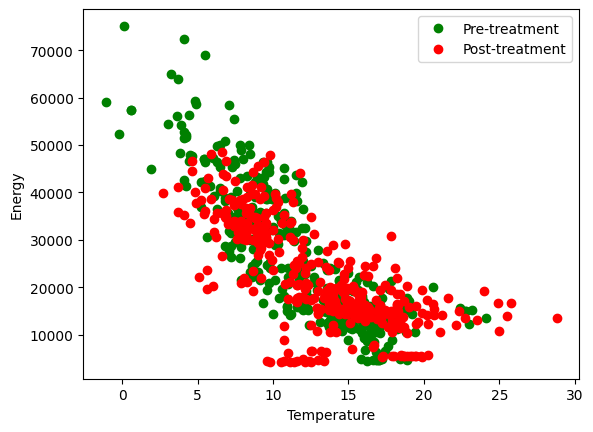

In [ ]:
# Example of positive (relative effect) locations with negative change in intercept and positive change in betas
plt.plot(data.query("(location_id==2147637) and (date < '2021-11-16')")['temp'], data.query("location_id==2147637  and (date < '2021-11-16') ")['energy'], 'o', color='green', label='Pre-treatment')
plt.plot(data.query("(location_id==2147637) and (date >= '2021-11-16')")['temp'], data.query("location_id==2147637  and (date >= '2021-11-16') ")['energy'], 'o', color='red', label='Post-treatment')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
# Summary of statistics for positive locations with negative change in intercept and negative change in betas
stat_sig_location.query(f'location_id=={neginterc_negbetas_pos}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Regression analysis (negative group)

In [ ]:
# Run regression analysis on negative group
neg_id = neg['location_id'].tolist()
results_neg_group = regression_inference_analysis(data=data,
                                                  location_id_group=neg_id,
                                                  formula='energy ~ temp')

In [ ]:
# Double check on Home Profile --> not 100% reliable
# Query for Jersey: client_id == 6788630634
homeprofile_neg = home_profile.query(f'client_id == 6788630634 and location_id == {neg_id}')

# Discard locations that show anomalies --> for each effect, analysis performed by looking at the energy distribution discarding those locations with anomaly spikes
anomaly_neg = [1420702, 1802914, 1805139, 1805260, 1807811, 1808468, 1808684, 1809420, 1810064, 1811541, 1812171, 1816164, 1838724, 1839448, 1840220, 1840890, 4669699, 1803530, 1804997, 1805287, 1805336, 1806379, 1808040, 1420165, 1661572, 1801936, 1804007, 1807893, 1811677, 1420311, 1660530, 1660679, 1661085, 1661238, 1661610, 1661660, 1802570, 1802763, 1803450, 1803848, 1804494, 1806548, 1809096, 1809209, 1811082, 1811161, 1811197, 1811764, 1813645, 1814658, 1816277, 1817478, 1839421, 1841750, 1850211, 1896156, 2146589]

# Discard locations that show patterns --> for each effect, analysis performed by looking at the energy distribution discarding those locations with patterns not controllable by Eliq
pattern_neg = [1803920, 1802024, 1806294, 1839141, 1660626, 1661600, 1661813, 1809651, 2128370]

# Get rid of them
discarded_loc_neg = anomaly_neg + pattern_neg
for location_id in discarded_loc_neg:
    results_neg_group.drop(results_neg_group.query(f'location_id=={location_id}').index, inplace=True)
    neg.drop(neg.query(f'location_id=={location_id}').index, inplace=True)
results_neg_group.reset_index(drop=True, inplace=True)
neg.reset_index(drop=True,inplace=True)
results_neg_group

,location_id,intercept_pre,intercept_post,interceptChange,betas_pre,betas_post,betasChange,SE_intercept_pre,SE_intercept_post,SE_betas_pre,SE_betas_post,pvalue_intercept_pre,pvalue_intercept_post,pvalue_betas_pre,pvalue_betas_post,Z_score
0,1420066,16108.0,13239.0,-17.81,-386.0,-225.0,41.75,279.0,263.0,21.0,21.0,0.0,0.0,0.0,0.0,-5.43
1,1420076,125809.0,133935.0,6.46,-5953.0,-6922.0,-16.28,2506.0,2906.0,194.0,227.0,0.0,0.0,0.0,0.0,3.24
2,1420114,85567.0,61892.0,-27.67,-2703.0,-1828.0,32.37,2897.0,2664.0,221.0,209.0,0.0,0.0,0.0,0.0,-2.87
3,1420154,28383.0,27212.0,-4.12,-1020.0,-1017.0,0.28,482.0,464.0,37.0,36.0,0.0,0.0,0.0,0.0,-0.06
4,1420202,42017.0,35644.0,-15.17,-1358.0,-1024.0,24.62,930.0,830.0,72.0,65.0,0.0,0.0,0.0,0.0,-3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,2429634,40492.0,34409.0,-15.02,-1237.0,-980.0,20.75,1453.0,1113.0,112.0,82.0,0.0,0.0,0.0,0.0,-1.85
629,2430005,54418.0,31609.0,-41.92,-2546.0,-1264.0,50.35,1950.0,1258.0,150.0,92.0,0.0,0.0,0.0,0.0,-7.29
630,2505250,56017.0,53147.0,-5.12,-1857.0,-2033.0,-9.49,1787.0,1303.0,137.0,95.0,0.0,0.0,0.0,0.0,1.06
631,2532468,129742.0,97426.0,-24.91,-5602.0,-3805.0,32.08,2931.0,1580.0,221.0,117.0,0.0,0.0,0.0,0.0,-7.19


In [ ]:
# Get locations with different effects within negative group
loc_nosignchange_neg = results_neg_group.query('abs(Z_score)<1.960')['location_id'].tolist()
loc_immediate_effect_neg = results_neg_group.query('((abs(interceptChange) > 0) and (abs(betasChange) == 0)) and (abs(Z_score)>=1.960)')['location_id'].tolist()
loc_sustained_effect_neg = results_neg_group.query('((abs(interceptChange) == 0) and (abs(betasChange) > 0)) and (abs(Z_score)>=1.960)')['location_id'].tolist()
loc_immediate_sustained_effect_neg = results_neg_group.query('((abs(interceptChange) > 0) and (abs(betasChange) > 0)) and (abs(Z_score)>=1.960)')['location_id'].tolist()

print('Total number of locations with negative relative effect is:', len(results_neg_group))
print('Number of locations with no significant change is:',len(loc_nosignchange_neg))
print('Number of locations with immediate effect (intercept change only) is:',len(loc_immediate_effect_neg))
print('Number of locations with sustained effect (betas change only) is:',len(loc_sustained_effect_neg))
print('Number of locations with both immediate and sustained effect (intercept and betas change) is:',len(loc_immediate_sustained_effect_neg))

Total number of locations with negative relative effect is: 633
Number of locations with no significant change is: 246
Number of locations with immediate effect (intercept change only) is: 0
Number of locations with sustained effect (betas change only) is: 0
Number of locations with both immediate and sustained effect (intercept and betas change) is: 387


Those (all) locations that show both an immediate and a sustained effect can be further divided into 4 categories:
* Positive change in intercept and positive change in betas
* Positive change in intercept and negative change in betas
* Negative change in intercept and positive change in betas
* Negative change in intercept and negative change in betas

In [ ]:
# Since we have only locations registering both immediate and sustained effect, we further divide them depending the sign of both interceptChange and betasChange

# Get rid of those locations that exhibit no significant change
results_neg_group = results_neg_group[~results_neg_group['location_id'].isin(loc_nosignchange_neg)]
neg = neg[~neg['location_id'].isin(loc_nosignchange_neg)]


# Get locations with positive change in both intercept and betas
posinterc_posbetas_neg = results_neg_group.query('(interceptChange > 0) and (betasChange > 0)')['location_id'].tolist()

# Get locations with positive change in intercept but negative change in betas
posinterc_negbetas_neg = results_neg_group.query('(interceptChange > 0) and (betasChange <= 0)')['location_id'].tolist()

# Get locations with positive change in betas but negative change in intercept
neginterc_posbetas_neg = results_neg_group.query('(interceptChange <= 0) and (betasChange > 0)')['location_id'].tolist()

# Get locations with negative change in both intercept and betas
neginterc_negbetas_neg = results_neg_group.query('(interceptChange <= 0) and (betasChange <= 0)')['location_id'].tolist()

print('Total number of locations with negative relative effect and both immediate and sustained effect is:', len(loc_immediate_sustained_effect_neg))
print('Number of locations with positive change in both intercept and betas is:',len(posinterc_posbetas_neg))
print('Number of locations with positive change in intercept but negative change in betas is:',len(posinterc_negbetas_neg))
print('Number of locations with positive change in betas but negative change in intercept is:',len(neginterc_posbetas_neg))
print('Number of locations with negative change in both intercept and betas is:',len(neginterc_negbetas_neg))

Total number of locations with negative relative effect and both immediate and sustained effect is: 387
Number of locations with positive change in both intercept and betas is: 0
Number of locations with positive change in intercept but negative change in betas is: 57
Number of locations with positive change in betas but negative change in intercept is: 323
Number of locations with negative change in both intercept and betas is: 7


In [ ]:
# Summary of statistics for all negative locations
loc_id_res_neg = neg['location_id'].unique().tolist()
stat_sig_location.query(f'location_id=={loc_id_res_neg}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,3.870000e+02,387.000000,3.870000e+02,387.00000,387.000000,3.870000e+02,3.870000e+02,387.000000,387.000000,3.870000e+02,3.870000e+02,387.000000,387.00000,387.000000,387.00000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,1.828980e+06,24024.384134,8.792925e+06,32941.35124,3700.188398,1.205653e+07,1.354269e+06,-8916.967390,3700.188398,-3.263610e+06,1.354269e+06,-26.139147,10.65261,-26.139147,10.65261,0.015323,98.403566,-0.752997,-0.663876,-11.552791
std,2.164486e+05,12910.110268,4.725100e+06,17374.03986,2911.048040,6.358899e+06,1.065444e+06,6493.170397,2911.048040,2.376500e+06,1.065444e+06,10.967321,4.91466,10.967321,4.91466,0.016211,1.621119,0.110832,0.139180,15.301299
min,1.420066e+06,3540.040000,1.295655e+06,4107.99000,88.090000,1.503525e+06,3.224123e+04,-41238.420000,88.090000,-1.509326e+07,3.224123e+04,-63.370000,2.14000,-63.370000,2.14000,0.000000,94.510000,-0.940000,-0.890000,-51.760000
25%,1.804890e+06,14770.715000,5.406082e+06,20860.52500,1648.645000,7.634952e+06,6.034027e+05,-11764.965000,1648.645000,-4.305977e+06,6.034027e+05,-32.525000,7.18000,-32.525000,7.18000,0.000000,97.300000,-0.840000,-0.785000,-21.230000
50%,1.810474e+06,21415.370000,7.838026e+06,29407.79000,2920.270000,1.076325e+07,1.068820e+06,-7466.890000,2920.270000,-2.732882e+06,1.068820e+06,-25.470000,9.89000,-25.470000,9.89000,0.010000,99.100000,-0.780000,-0.670000,-10.710000
75%,1.839331e+06,30138.220000,1.103059e+07,41701.83000,4801.275000,1.526287e+07,1.757266e+06,-4181.415000,4801.275000,-1.530398e+06,1.757266e+06,-18.065000,13.10500,-18.065000,13.10500,0.030000,99.800000,-0.690000,-0.560000,-2.860000
max,4.697447e+06,86373.700000,3.161277e+07,119646.23000,16587.150000,4.379052e+07,6.070897e+06,-567.950000,16587.150000,-2.078699e+05,6.070897e+06,-6.280000,34.23000,-6.280000,34.23000,0.050000,100.000000,-0.410000,-0.400000,75.610000


In [ ]:
# Compute confidence interval 95% values for positive (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Avg) {col}', neg[col].apply(pd.Series).mean().astype(int).tolist() )

(Avg) 95_CI_Average [25762, 40267]
(Avg) 95_CI_Cumulative [9429171, 14737808]
(Avg) 95_CI_Absolute_Effect_Average [-16242, -1738]
(Avg) 95_CI_Absolute_Effect_Cumulative [-5944884, -636246]
(Avg) 95_CI_Relative_Effect_Average [-47, -5]
(Avg) 95_CI_Relative_Effect_Cumulative [-47, -5]


In [ ]:
# Compute confidence interval 95% values for positive (avg) relative effects
columns = ['95_CI_Average',
           '95_CI_Cumulative',
           '95_CI_Absolute_Effect_Average',
           '95_CI_Absolute_Effect_Cumulative',
           '95_CI_Relative_Effect_Average',
           '95_CI_Relative_Effect_Cumulative']
for col in columns:
    print(f'(Median) {col}', neg[col].apply(pd.Series).median().astype(int).tolist() )

(Median) 95_CI_Average [22782, 35098]
(Median) 95_CI_Cumulative [8338526, 12845932]
(Median) 95_CI_Absolute_Effect_Average [-13484, -981]
(Median) 95_CI_Absolute_Effect_Cumulative [-4935253, -359408]
(Median) 95_CI_Relative_Effect_Average [-44, -3]
(Median) 95_CI_Relative_Effect_Cumulative [-44, -3]


In [ ]:
# Compute the median values for positive (avg) relative effects
columns = ['Actual_Average',
           'Prediction_Average',
           'Absolute_Effect_Average',
           'Relative_Effect_Average',
           'Posterior_tail_area_probability_p']
for col in columns:
    print(f'Median for {col}', neg[col].sort_values().median())

Median for Actual_Average 21415.37
Median for Prediction_Average 29407.79
Median for Absolute_Effect_Average -7466.89
Median for Relative_Effect_Average -25.47
Median for Posterior_tail_area_probability_p 0.01


In [ ]:
# Summary of statistics for negative locations with positive change in intercept and positive change in betas
stat_sig_location.query(f'location_id=={posinterc_posbetas_neg}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Summary of statistics for negative locations with positive change in intercept and negative change in betas
stat_sig_location.query(f'location_id=={posinterc_negbetas_neg}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,5.700000e+01,57.000000,5.700000e+01,57.000000,57.000000,5.700000e+01,5.700000e+01,57.000000,57.000000,5.700000e+01,5.700000e+01,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,1.805392e+06,28274.364737,1.034842e+07,37046.263684,4077.738246,1.355893e+07,1.492452e+06,-8771.899649,4077.738246,-3.210515e+06,1.492452e+06,-21.294912,9.979298,-21.294912,9.979298,0.019649,97.932281,-0.718246,-0.750702,6.370877
std,1.599432e+05,13999.174440,5.123698e+06,20116.045868,3569.727932,7.362473e+06,1.306520e+06,7933.019345,3569.727932,2.903485e+06,1.306520e+06,10.777927,5.302550,10.777927,5.302550,0.016471,1.619232,0.144817,0.117805,14.883200
min,1.420076e+06,6292.390000,2.303014e+06,7119.570000,335.940000,2.605763e+06,1.229555e+05,-39507.730000,335.940000,-1.445983e+07,1.229555e+05,-52.020000,2.970000,-52.020000,2.970000,0.000000,94.510000,-0.900000,-0.890000,-14.060000
25%,1.805401e+06,16577.910000,6.067514e+06,22526.930000,1502.520000,8.244855e+06,5.499210e+05,-10948.040000,1502.520000,-4.006984e+06,5.499210e+05,-28.470000,5.860000,-28.470000,5.860000,0.010000,96.800000,-0.830000,-0.850000,-2.130000
50%,1.810045e+06,26380.530000,9.655274e+06,33532.210000,2892.780000,1.227279e+07,1.058758e+06,-6714.180000,2892.780000,-2.457389e+06,1.058758e+06,-19.600000,9.980000,-19.600000,9.980000,0.020000,98.300000,-0.760000,-0.780000,1.320000
75%,1.838644e+06,35636.620000,1.304300e+07,49821.660000,5642.990000,1.823473e+07,2.065336e+06,-3461.890000,5642.990000,-1.267051e+06,2.065336e+06,-12.950000,13.300000,-12.950000,13.300000,0.030000,99.300000,-0.610000,-0.670000,9.260000
max,2.361418e+06,65795.090000,2.408100e+07,105302.810000,16587.150000,3.854083e+07,6.070897e+06,-796.220000,16587.150000,-2.914150e+05,6.070897e+06,-6.280000,27.510000,-6.280000,27.510000,0.050000,100.000000,-0.410000,-0.460000,75.610000


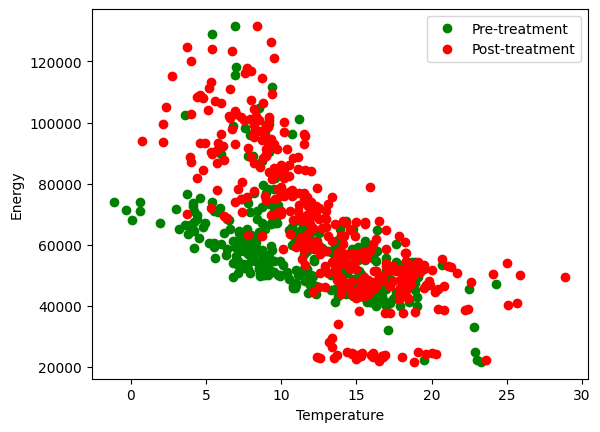

In [ ]:
# Example of negative (relative effect) locations with positive change in intercept and negative change in betas
plt.plot(data.query("(location_id==1809079) and (date < '2021-12-22')")['temp'], data.query("location_id==1809079  and (date < '2021-12-22') ")['energy'], 'o', color='green', label='Pre-treatment')
plt.plot(data.query("(location_id==1809079) and (date >= '2021-12-22')")['temp'], data.query("location_id==1809079  and (date >= '2021-12-22') ")['energy'], 'o', color='red', label='Post-treatment')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
# Summary of statistics for negative locations with negative change in intercept and positive change in betas
stat_sig_location.query(f'location_id=={neginterc_posbetas_neg}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,3.230000e+02,323.000000,3.230000e+02,323.000000,323.000000,3.230000e+02,3.230000e+02,323.000000,323.000000,3.230000e+02,3.230000e+02,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000
mean,1.833392e+06,23212.177833,8.495657e+06,32179.968947,3668.419257,1.177787e+07,1.342641e+06,-8967.791331,3668.419257,-3.282212e+06,1.342641e+06,-27.113498,10.886006,-27.113498,10.886006,0.014830,98.457399,-0.761053,-0.646873,-15.262136
std,2.271279e+05,12498.016917,4.574274e+06,16703.500681,2795.416826,6.113481e+06,1.023123e+06,6242.446680,2795.416826,2.284736e+06,1.023123e+06,10.830229,4.822244,10.830229,4.822244,0.016139,1.615235,0.101410,0.137375,12.383716
min,1.420066e+06,4392.500000,1.607656e+06,5628.770000,238.410000,2.060128e+06,8.725661e+04,-41238.420000,238.410000,-1.509326e+07,8.725661e+04,-63.370000,2.850000,-63.370000,2.850000,0.000000,94.510000,-0.940000,-0.890000,-51.760000
25%,1.804758e+06,14678.230000,5.372233e+06,20540.205000,1667.505000,7.517714e+06,6.103060e+05,-11832.435000,1667.505000,-4.330670e+06,6.103060e+05,-33.020000,7.540000,-33.020000,7.540000,0.000000,97.450000,-0.840000,-0.760000,-23.770000
50%,1.810556e+06,20745.530000,7.592865e+06,28947.810000,2947.110000,1.059490e+07,1.078643e+06,-7548.180000,2947.110000,-2.762634e+06,1.078643e+06,-26.090000,9.940000,-26.090000,9.940000,0.010000,99.200000,-0.780000,-0.660000,-13.730000
75%,1.839331e+06,28629.925000,1.047855e+07,41078.205000,4740.275000,1.503462e+07,1.734941e+06,-4243.760000,4740.275000,-1.553215e+06,1.734941e+06,-19.310000,13.105000,-19.310000,13.105000,0.025000,99.800000,-0.700000,-0.540000,-6.250000
max,4.697447e+06,86373.700000,3.161277e+07,119646.230000,16044.490000,4.379052e+07,5.872284e+06,-1236.260000,16044.490000,-4.524721e+05,5.872284e+06,-6.990000,34.230000,-6.990000,34.230000,0.050000,100.000000,-0.410000,-0.400000,27.080000


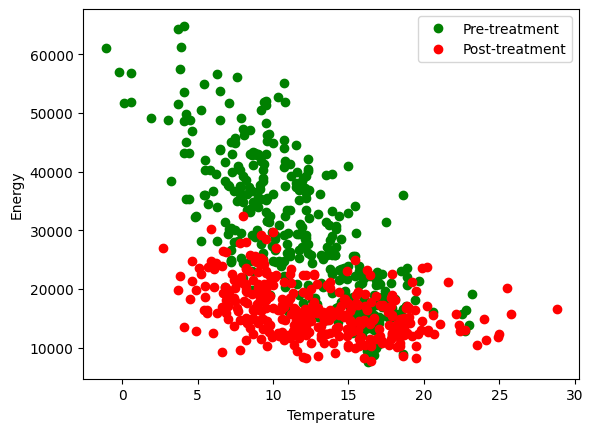

In [ ]:
# Example of negative (relative effect) locations with negative change in intercept and positive change in betas
plt.plot(data.query("(location_id==1804190) and (date < '2021-09-04')")['temp'], data.query("location_id==1804190  and (date < '2021-09-04') ")['energy'], 'o', color='green', label='Pre-treatment')
plt.plot(data.query("(location_id==1804190) and (date >= '2021-09-04')")['temp'], data.query("location_id==1804190  and (date >= '2021-09-04') ")['energy'], 'o', color='red', label='Post-treatment')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
# Summary of statistics for negative locations with negative change in intercept and negative change in betas
stat_sig_location.query(f'location_id=={neginterc_negbetas_neg}').describe()

,location_id,Actual_Average,Actual_Cumulative,Prediction_Average,Prediction_Std_Dev,Prediction_Cumulative,Prediction_Cumulative_Std_Dev,Absolute_Effect_Average,Absolute_Effect_Std_Dev,Absolute_Effect_Cumulative,Absolute_Effect_Cumulative_Std_Dev,Relative_Effect_Average,Relative_Effect_Std_Dev,Relative_Effect_Cumulative,Relative_Effect_Cumulative_Std_Dev,Posterior_tail_area_probability_p,Posterior_prob_of_a_causal_Effect,corr_pre,corr_post,percChange_corr
count,7.000000e+00,7.000000,7.000000e+00,7.00000,7.000000,7.000000e+00,7.000000e+00,7.000000,7.000000,7.000000e+00,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1.817507e+06,26894.918571,9.843540e+06,34647.99000,2091.772857,1.268116e+07,7.655888e+05,-7753.071429,2091.772857,-2.837624e+06,7.655888e+05,-20.625714,5.365714,-20.625714,5.365714,0.002857,99.757143,-0.664286,-0.741429,13.657143
std,1.607020e+04,17143.674102,6.274584e+06,21786.36035,1562.767899,7.973808e+06,5.719728e+05,5638.450925,1562.767899,2.063673e+06,5.719728e+05,7.048411,1.912597,7.048411,1.912597,0.004880,0.423703,0.135875,0.098392,15.188042
min,1.804743e+06,3540.040000,1.295655e+06,4107.99000,88.090000,1.503525e+06,3.224123e+04,-15520.280000,88.090000,-5.680423e+06,3.224123e+04,-31.450000,2.140000,-31.450000,2.140000,0.000000,99.000000,-0.860000,-0.870000,-5.800000
25%,1.805637e+06,17365.650000,6.355827e+06,20597.65000,970.135000,7.538739e+06,3.550697e+05,-11879.300000,970.135000,-4.347823e+06,3.550697e+05,-26.040000,4.365000,-26.040000,4.365000,0.000000,99.650000,-0.750000,-0.830000,4.375000
50%,1.811529e+06,22821.830000,8.352789e+06,30782.50000,2302.590000,1.126639e+07,8.427478e+05,-7960.670000,2302.590000,-2.913605e+06,8.427478e+05,-16.690000,5.490000,-16.690000,5.490000,0.000000,100.000000,-0.690000,-0.700000,14.040000
75%,1.826768e+06,35429.835000,1.296732e+07,49770.83000,2830.130000,1.821612e+07,1.035827e+06,-3232.000000,2830.130000,-1.182912e+06,1.035827e+06,-15.165000,6.755000,-15.165000,6.755000,0.005000,100.000000,-0.550000,-0.655000,19.305000
max,1.841467e+06,56311.590000,2.061004e+07,66908.48000,4651.200000,2.448850e+07,1.702339e+06,-567.950000,4651.200000,-2.078699e+05,1.702339e+06,-13.830000,7.690000,-13.830000,7.690000,0.010000,100.000000,-0.500000,-0.650000,40.000000


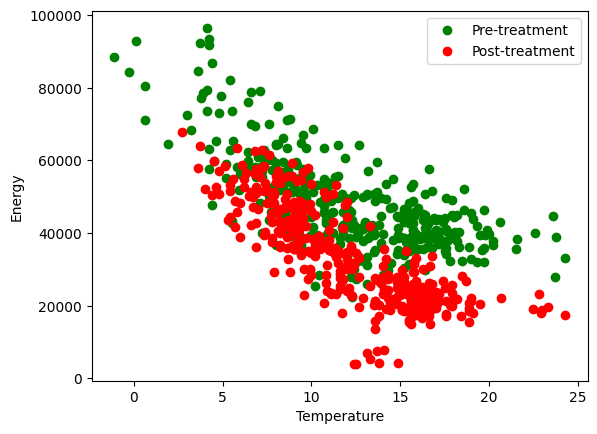

In [ ]:
# Example of negative (relative effect) locations with negative change in intercept and negative change in betas
plt.plot(data.query("(location_id==1804743) and (date < '2021-04-10')")['temp'], data.query("location_id==1804743  and (date < '2021-04-10') ")['energy'], 'o', color='green', label='Pre-treatment')
plt.plot(data.query("(location_id==1804743) and (date >= '2021-04-10')")['temp'], data.query("location_id==1804743  and (date >= '2021-04-10') ")['energy'], 'o', color='red', label='Post-treatment')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.legend()
plt.show()

#### Step 7 - Draw conclusions

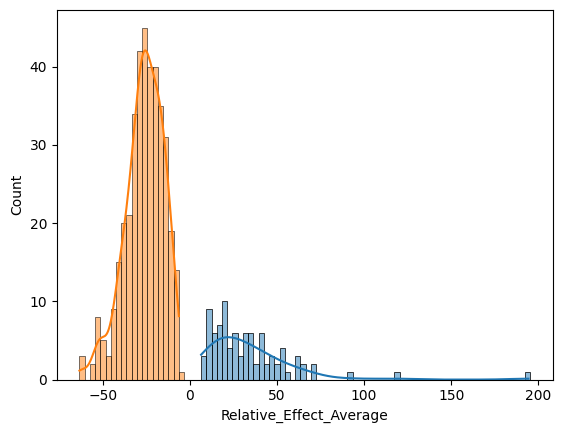

In [ ]:
# Histogram negative and positive average relative effects
plot = sns.histplot(data=pos, x='Relative_Effect_Average', kde=True, binwidth=3)
plot = sns.histplot(data=neg, x='Relative_Effect_Average', kde=True, binwidth=3)
#plot.set(xlim=(-100, 100))

**Inference analysis conclusions**
---
As previously discussed, after obtaining results from the **Bayesian Structural Time Series** (BSTS), we've chosen to conduct a more detailed analysis using the **tfcausalimpact Hamiltonian Monte Carlo** (hmc). The reason for this choice is related to its more consistent and accurate results, although at the expense of longer computational time.

**Statistical significance**: Approximately 30\% of the locations (*1495* out of 5011) exhibited a statistically significant impact (either negative or positive), where significance was determined by a p-value less than or equal to 5\%.

**Bimodal distribution**: The (average) relative effect distribution revealed a bimodal shape, indicating the presence of two distinct groups — one with a negative impact and the other with a positive impact.

**Correlation analysis**: To detect  structural (upward and downward) shifts, (Pearson) correlation coefficients between energy consumption and (outdoor) temperature were computed for both pre- and post-treatment periods.\
Note that we would expect strong negative correlations for those locations with electrical heating systems and therefore locations that exhibit negligible or positive correlation probably do not use electricity for heating in any meaningful way, or use it in a way difficult to detect. \
After comparing the resulting coefficients we discarded all those locations that had switched fuels or registrered no electricity usage over both pre- and post-treatment period (i.e., 652 out of 1495 locations, 44\%), while we kept for further analysis only those locations without any change in fuel (i.e., 843 out of 1495 locations, 56\%). The latter locations, throughout the entire analysis period, consistently utilized electricity as their primary fuel source (i.e., we focus on strong negative correlation values for both pre- and post-treatment period, hence considering coefficient lower than -0.40); conversely, the former represent all other locations that experienced a change in fuel during the analysis period, as well as locations where no change was observed but they never relied on electricity as a fuel source (i.e., locations that exhibit strong positive correlation values or values close to zero).

**Negative and positive relative effect group analysis**: Now, we have further divided the locations with no change in fuel into two distinct groups: those with positive and negative relative effects. This decision was made due to the bimodal shape of the average relative effect distribution. The separation allows for a detailed analysis of each group, providing better insights into the distinct characteristics and impacts of both.\
On the negative side, our boundaries are much more constrained compared to the positive side. A quick glance at the distribution of negative and positive relative effects reveals a skewed distribution in the positive groups. Despite some outliers, it remains challenging in both groups to attribute an increase or decrease of >50/60% to Eliq's energy management solution.

**Negative (relative effect) group**: Statistically significant locations are *699* out of 843, indicating that approx. 83\% of the locations have a significant negative impact, i.e., a decrease in energy consumption.\
*Average* results:
* **Actual energy consumption (observed)** is approx 24,213 wh (24 kwh) - median is 21,766 wh (21 kwh), while **predicted energy consumption (counterfactual)** is approx 32,504 wh (32 kwh) - median is 29,407 wh (29 kwh) , with **variability** of 17,143 wh (17 kwh) and **95% confidence interval** of [25686, 39465]
* **Absolute effect** is -8,291 wh (-8 kwh), with **variability** of 6,102 wh (6 kwh) and **95% confidence interval** of [-15252, -1,473] (median 95\% CI [-12,835, -811])
* **Relative effect** of around -24\% (median -23\%) indicating a negative effect ('minus´ symbol), ie decrease in energy consumption. **Variability** is around 10\%, with -30\% and -16\% as **25th** and **75th percentiles**, respectively. The **95% confidence interval** is [-44\%, -4\%] (median 95\% CI [-42\%, -3\%]).

*Cumulative* results:
* **Actual energy consumption (observed)** is approx 8,861,977 wh (8,861 kwh), while **predicted energy consumption (counterfactual)** is approx 11,896,810 wh (11,896 kwh), with **variability** of 6,274,621 wh (6,274 kwh) and **95% confidence interval** of [9401125, 14444447]
* **Absolute effect** is -3,034,829 wh (-3,034 kwh), with **variability** of 2,233,462 wh (2,233 kwh) and **95% confidence interval** of [-5582471, -539148] (median 95\% CI [-4697955, -296853])

*Interpretation of negative relative effect results*: By isolating the negative relative effect group, we obtain more consistent and reliable data. As observed above, on average (at the cumulative level), there is a 24% decrease in energy consumption. This reduction translates into a daily saving of approximately 8,291 Wh (8 kwh) and a yearly saving of 3,034,829 Wh (3,034 kwh), roughly equating to less than £900 annually. These locations demonstrate a substantial decrease in energy consumption within just one year after adopting Eliq's energy management solution and its insights platform.

**Positive (relative effect) group**: Statistically significant locations are *144* out of 843, indicating that approx. 17\% of the locations have a significant positive impact, i.e., an increase in energy consumption.\
*Average* results:
* **Actual energy consumption (observed)** is approx 25,618 wh (25 kwh) - median is 22,666 wh (22 kwh), while **predicted energy consumption (counterfactual)** is approx 19,009 wh (19 kwh) - median is 16,888 wh (16 kwh) , with **variability** of 10,433 wh (10 kwh) and **95% confidence interval** of [14049, 23846]
* **Absolute effect** is 6,608 wh (6 kwh), with **variability** of 5,805 wh (5 kwh) and **95% confidence interval** of [1771, 11658] (median 95\% CI [696, 8112])
* **Relative effect** of around 39\% (median 27\%) indicating a powitive effect ('plus´ symbol), ie increase in energy consumption. **Variability** is around 40\%, with 18\% and 45\% as **25th** and **75th percentiles**, respectively. The **95% confidence interval** is [10\%, 68\%] (median 95\% CI [4\%, 49\%]). The discrepancy between the mean and median values of the relative effect is attributed to a couple of extreme positive values that register values greater than +100\%.

*Cumulative* results:
* **Actual energy consumption (observed)** is approx 9,376,290 wh (9,376 kwh), while **predicted energy consumption (counterfactual)** is approx 6,957,509 wh (6,957 kwh), with **variability** of 3,818,483 wh (3,818 kwh) and **95% confidence interval** of [5142187, 8727795]
* **Absolute effect** is 2,418,781 wh (2,418 kwh), with **variability** of 2,124,721 wh (2,124 kwh) and **95% confidence interval** of [648495, 4234102] (median 95\% CI [255004, 2969080])

*Interpretation of positive relative effect results*: By focusing on the positive relative effect group, we obtain more consistent and reliable data compared to the aggregate level, despite observing a skewed distribution on the right. As observed above, on average (at the cumulative level), there is a 39% increase in energy consumption, with a median value of 27%. This increment translates into a daily expenses of approximately 6,608 Wh (6 kwh) and a yearly expenses of 2,418,781 Wh (2,418 kwh). These locations demonstrate a substantial increase in energy consumption within just one year after adopting Eliq's energy management solution and its insights platform.

**Plus - double check on Home Profile**: Although Home Profile is not entirely reliable, we double checked locations to identify anomalies and patterns that could potentially cause alterations in the relative effect:
* Anomalies are mainly spikes in different periods of the year, altering the relative effect
* Patterns often lead to an increment or reduction in energy consumption that alterates the resulting relative effect

NB. Home profile – this unique data source helps us get more information from energy consumers about their homes and provide a more tailored service with otherwise limited information

**Findings for negative results**:\
*Anomalies*:
* Locations 1420702, 1802914, 1805139, 1805260, 1807811, 1808468, 1808684, 1809420, 1810064, 1811541, 1812171, 1816164, 1838724, 1839448, 1840220, 1840890, 4669699, 1803530 1804997 1805287 1805336 1806379, 1808040, 1420165, 1661572, 1801936, 1804007, 1807893, 1811677, 1420311, 1660530, 1660679, 1661085, 1661238, 1661610, 1661660, 1802570, 1802763, 1803450, 1803848, 1804494, 1806548, 1809096, 1809209, 1811082, 1811161, 1811197, 1811764, 1813645, 1814658, 1816277, 1817478, 1839421, 1841750, 1850211, 1896156, 2146589

*Patterns*:
* Location 1803920 changed heating system from oil boiler with radiators to modern slimline night storage heaters in the mid post-treatment period
* Location 1802024 registered 3 people at intervention time, then decreased to 2 in the mid post-treatment period. Immediate effect might be due to this pattern
* Location 1806294 registered 2 people at intervention time, then decreased to 1 six months after the end of the analysis period. It might have happened that a person left the house before the second registration, meaning that the decrease in energy consumption might be due to this pattern
* Location 1839141 registered 3 people at intervention time, then decreased to 2 in the mid post-treatment period. The effect might be due to this pattern
* Location 1660626 registered 3 people at intervention time, then decreased to 2 in the mid post-treatment period. The effect might be due to this pattern
* Location 1661600 registered 3 people at mid post-treatment period, then 3 months before the end of the analysis period, it decreased to 2. The effect might be due to this pattern
* Location 1661813: Right after the beginning of the post-treatment period, the number of people decreased from 4 to 3. The effect might be due to this pattern
* Location 1809651: At mid post-treatment period, it changed the heating system from heat pump to electric boiler
* Location 2128370: At mid post-treatment period, it changed the heating system from night storage heaters to electric boiler

**Findings for positive results**:\
*Anomalies*:
* Locations 1818582, 1818973, 1420099, 1818827, 2645378, 1420131 1815341 1817982 and 1855638

*Patterns*:
* Location 1661645 registered 2 EVs at half post-treatment period. Initial information included only house type, persons (constant at 5), bedrooms (constant at 3), and primary heating type (night storage). The increase in energy consumption might be associated with the electric vehiles
* Location 1817703 registered an increase in people from 1 to 2 in late post-treatment. Previous info was mid post-treatment (summer time). Trend indicates a winter increment in energy consumption, possibly due to an increase in the number of people
* Location 1810491 shows an increase in energy consumption after the intervention date (during winter). However, Home Profile timestamps for the data are registered more than one year after the intervention. It is possible that changes occurred during the intervention period but were registered late. An example is the increase in the number of people living in the house from 2 to 3 with a modern electrical heating system.
* Location 1838015 demonstrates an increment in energy consumption related to an increase in electric devices in the house which might have been present since the beginning of the analysis, but the Home Profile timestamps indicate an increase since the intervention. It could be due to feedback from Eliq's solution recommending less expensive or less polluting devices that are, nevertheless, more expensive for electricity. Locations exhibiting this pattern are kept in the analysis
* Location 1661088 switched to an electric boiler for heating in the last 2 months, leading to an overall increase in energy consumption - this case was not detected and discarded in the correlation analysis since it showed a low level of correlation due to the late fuel switch
* Location 1855638 exhibits a similar pattern as the previous one, indicating an increase in the number of electric devices. In the post-treatment period, we see a different energy consumption pattern, possibly due to a new tenant or owner moving into the house
* Location 1662084 shows that at intervention time, the people count was 1, and we have no information about the pre-treatment period. The pattern indicates that a new tenant/owner moved in at the intervention time
* Location 1660366 shows a significant increase in energy consumption (+126.53%) during the post-treatment period could be attributed to a family of 4 moving into the house during the intervention analysis, altering the results
* Location 1660610: after the beginning of the post-treatment period, it increased the number of people from 2 to 6 for a period that lasts a few months beyond our analysis period, then returned to 2. The increase in energy consumption is surely due to this pattern
* Location 1803208: In the last 3 months of the post-treatment period, it registered 4 people, but a new registration on the home profile 2 years later reported an increment to 5 people. Right after the first registration, a marked increment in energy consumption is observed, possibly due to the new person living in the house, but we cannot be 100% sure since we have no info for the next 2 years
* Location 1815646: For the last 9 months in the post-treatment period, the number of people increased from 3 to 4, then returned to 3 after the ending of the analysis period. The increase in energy consumption is due to this fact
* Location 1818561 registers 2 people in the intervention time, but increased to 3 two years after the end of our analysis period. The trend is clear, and it might be that the new occupant entered the house before being registered in the Home Profile
* Location 2148332: During the intervention time, it registered an increment in the number of people from 1 to 2. Unavailable information for the entire post-treatment period
* Location 1814587 exhibits a significant increase in energy consumption of +360%. This can be attributed to the transformation of the property. Before the intervention, the house type was recorded as a flat middle house, while in the post-treatment period, it changed to a mid-terraced house. This cahnge suggests that the property underwent renovation or extension, leading to an observed increment in energy consumption

Upon a close examination we have identified certain locations consistently manifesting anomalies and patterns not controllable by Eliq. Consequently, we have made the decision to discard such locations, both for positive and negative results. Specifically, we discarded 18 locations from the positive group and 66 from the negative group. In other words, we have transitioned from 843 locations to 759 locations.

**Regression (inference) analysis**: To gain a deeper understanding of the differences between the two groups, especially the reasons behind some locations show a positive or negative relative effect, we conducted a regression analysis on temperature (as the regressor/independent variable) and energy data (as the dependent variable) for each period.

Why? This allowed us to compare intercepts for the pre and post-treatment periods, as well as their beta values.\
How? *Z-test*: It aims of testing whether the intervention had a significant impact on the relationship between temp and energy.\
The z-score is computed as $$ Z = \frac{{\beta_1 - \beta_2}}{{\sqrt{{SE_{\beta_1}^2 + SE_{\beta_2}^2}}}} $$
where Beta 1 is beta of pre treatment period, Beta 2 is beta of post treatment period, SE Beta 1 is Standard Error of Beta 1 and SE Beta 2 is Standard Error of Beta 2 (paper: Clogg, 1995)\
Null Hypothesis (No significant change in betas)
$$ H_0 : \beta_1 = \beta_2 $$
Alternative Hypothesis (Significant change in betas)
$$ H_1 : \beta_1 \neq \beta_2 $$
Procedure: Compare the absolute value of the z score with the critical value for a two-tailed test at the 5% level of significance (i.e., if the type of test is two-tailed, then the critical value is ±1.960). If the absolute value of the z score is greater than the critical z value (1.960), then reject the null hypothesis.

As mentioned, the aim was to investigate each effect, thereby understanding if the policy intervention:
1. has no significant change, i.e., both betas are not statistically significant --> it suggests that the intervention did not have a significant impact on the relationship between temp and energy, i.e., the observed difference in the coefficients is likely due to random variation rather than a true change in the relationship
2. has significant change (both an immediate and a sustained effect), i.e., significant change in both intercept and slopes. This could be due to the implementation of more energy-efficient practices or changes in the overall energy consumption habits within the locations, as well as Eliq's solution might have influenced the way temperature affects energy use, indicating a more nuanced and dynamic response to environmental conditions

Results:
1. No significant change: 36 positive locations (4% out of 759 total locs, 29% out of 126 no significant locs) and 246 negative locations (32% out of 759 total locs, 39% out of 633 significant locs)
2. Both immediate and sustained effect: 90 positive locations (11% out of 759 total locs, 71% out of 126 no significant locs) and 387 negative locations (51% out of 759 total locs, 61% out of 633 significant locs)

After performing regression analysis for each location during both pre and post treatment period and conducting the necessary comparisons, most of the locations (i.e., both for positive and negative groups) show both an immediate and a sustained effect - they can be further divided into 4 categories:
* Positive change in intercept and positive change in betas --> locations with an upward shift in baseline energy consumption (elec) and increase in sensitivity to temperature in post-treatment period\
Why? Adoption of Eliq's energy management solution may have led to increased energy (elec) usage at the baseline, possibly due to behavioral changes, increased elec devices usage, or other external influences not related to temp. Users may have become more responsive to temp changes, leading to a higher impact on energy consumption as temp fluctuate
* Positive change in intercept and negative change in betas --> locations with an upward shift in baseline energy consumption (elec) and decrease in sensitivity to temperature in post-treatment period\
Why? As before, the upward shift in baseline energy consumption could be attributed to factors other than temperature. Users may have become less responsive to temperature changes, mitigating the impact on energy consumption
* Negative change in intercept and positive change in betas --> locations with an downward shift in baseline energy consumption (elec) and increase in sensitivity to temperature in post-treatment period\
Why? The downward shift in baseline energy consumption could be linked to energy-saving behaviors encouraged by Eliq's solution, leading to a more effciient usage habits. Users may have become more responsive to temperature changes, the impact of temp on energy consumption is more pronounced
* Negative change in intercept and negative change in betas --> locations with an downward shift in baseline energy consumption (elec) and decrease in sensitivity to temperature in post-treatment period\
Why? The downward shift in baseline energy consumption may be indicative of successful energy-saving measures implemented by users. Users may have become less responsive to temperature changes.  This group of locations is achieving a reduction in overall energy use, and the energy consumption is becoming less dependent on temperature fluctuations, indicating a successful implementation of Eliq's energy management solution

*Findings of negative results (387) with regression analysis*:
* *Positive intercept change & Positive betas change* (0 locations): No locations show these patterns
* *Positive intercept change & Negative betas change* (57 locations): 14% of the 387 significant positive locations and 7% of the 759 total aggregated locations
* *Negative intercept change & Positive betas change* (323 locations): 83% of the 387 significant positive locations and 42% of the 759 total aggregated locations
* *Negative intercept change & Negative betas change* (7 locations):  1% of the 387 significant positive locations and 0.3% of the 759 total aggregated locations

*Findings of positive results (90) with regression analysis*:
* *Positive intercept change & Positive betas change* (3 locations): 3% of the 90 significant negative locations and 0.4% of the 759 total aggregated locations
* *Positive intercept change & Negative betas change* (70 locations): 77% of the 90 significant negative locations and 9% of the 759 total aggregated locations
* *Negative intercept change & Positive betas change* (17 locations): 19% of the 90 significant negative locations and 2% of the 759 total aggregated locations
* *Negative intercept change & Negative betas change* (0 locations): No locations show these patterns

**Summary negative and positive relative effect group analysis**: After discarding locations that exhibit anomalies or patterns not controllable by Eliq, as well as those locations with no significant effect in regression analysis, we further analyzed the two groups, aiming to have a clearer picture of the locations comprising them.

**Negative (relative effect) group**: Statistically significant (negative) locations are *387* out of 477 locs with significant change, indicating that approx. 81\% of the locations have a significant negative impact. \
First, to address the business-related questions, we examine the results from regression analyses between energy and temp, performed on negative group:
* Out of 477 locations with significant change, *387* locations (81%) showed a significant change in both intercept and betas. However, the remaining 246 locations did not show a significant change. Almost all locations either experienced a downward shift in baseline energy consumption associated with factors other than temp (e.g., users did behavioral changes in how they use their energy, eg hot water, washings, etc) or an encouraging trend of changing energy habits and elec devices, especially altering their sensitivity to temp, eg lower set on termostat. This illustrates the flexibility of Eliq's solution in adapting to different user contexts and lifestyles, enabling effective energy savings in various situations, as well as an increasing gradient in the level of accuracy of customization and personalization of the solution to users

*Average* (aggregate) results:
* **Actual energy consumption (observed)** is approx 24,024 wh (24 kwh) - median is 21,415 wh (21 kwh), while **predicted energy consumption (counterfactual)** is approx 32,941 wh (32 kwh) - median is 29,407 wh (29 kwh) , with **variability** of 17,090 wh (17 kwh) and **95% confidence interval** of [25762, 40267]
* **Absolute effect** is -8,916 wh (-8 kwh), with **variability** of 6,493 wh (6 kwh) and **95% confidence interval** of [-16242, -1738] (median 95\% CI [-13,484, -981])
* **Relative effect** of around -26\% (median -25\%) indicating a negative effect ('minus´ symbol), ie decrease in energy consumption. **Variability** is around 10\%, with -32\% and -18\% as **25th** and **75th percentiles**, respectively. The **95% confidence interval** is [-47\%, -3\%] (median 95\% CI [-44\%, -3\%]).

*Cumulative* (aggregate) results:
* **Actual energy consumption (observed)** is approx 8,792,925 wh (8,792 kwh), while **predicted energy consumption (counterfactual)** is approx 12,056,530 wh (12,056 kwh), with **variability** of 6,358,899 wh (6,358 kwh) and **95% confidence interval** of [9429171, 14737808]
* **Absolute effect** is -3,263,610 wh (-3,263 kwh), with **variability** of 2,376,500 wh (2,376 kwh) and **95% confidence interval** of [-5944884, -636246] (median 95\% CI [-4935253, -359408])

*Interpretation of negative relative effect results*: The results align with those obtained before discarding anomalies and patterns, and no significant change. This indicates that extreme values (e.g., values lower than -40/-50%) are not driven by any patterns or anomalies but instead are the result of Eliq's energy management solution achieving outstanding results. It's important to note that there is always room for uncertainty, and there might be cases where patterns not registered in Home Profile or other external variables influencing energy consumption are not detected correctly by the model. As observed earlier, on average (at the cumulative level), there is a 26% decrease in energy consumption. This reduction translates into a daily saving of approximately 8,916 Wh (8 kwh) and a yearly saving of 3,263,610 Wh (3,263 kwh), roughly equating to less than £900 annually. As mentioned, these locations demonstrate a downward shift in baseline energy consumption within just one year after adopting Eliq's energy management solution and its insights platform.

**Positive (relative effect) group**: Statistically significant (positive) locations are *90* out of 477 locs with significant change, indicating that approx. 19\% of the locations have a significant positive impact. \
First, to address the business-related questions, we examine the results from regression analyses between energy and temp, performed on positive group:
* Out of 126 locations with significant change, *90* locations (19%) showed a significant change in both intercept and betas. However, the remaining 36 locations did not show a significant change. The majority of the locations with significant change showed an upward shift in baseline energy consumption and a negative change in betas, suggesting (e.g.) possible feedback from Eliq's solution recommending less expensive or less polluting devices, which may be more expensive for elec in the short term, but showed to be beneficial in the long term by changing the sensitivity of energy consumption to temp. As stated, these are assumptions that can be validated only by having more reliable information from Home Profile. It is important to note that some of these locations might indicate a failure of the solution to bring energy savings - this could occur if locations did not engage with the insights provided or misunderstood the recommendations

*Average* (aggregate) results:
* **Actual energy consumption (observed)** is approx 26,296 wh (26 kwh) - median is 22,785 wh (22 kwh), while **predicted energy consumption (counterfactual)** is approx 20,249 wh (20 kwh) - median is 17,487 wh (17 kwh) , with **variability** of 11,487 wh (11 kwh) and **95% confidence interval** of [15658, 24711]
* **Absolute effect** is 6,046 wh (6 kwh), with **variability** of 4,194 wh (4 kwh) and **95% confidence interval** of [1584, 10638] (median 95\% CI [949, 7858])
* **Relative effect** of around 33\% (median 27\%) indicating a positive effect ('plus´ symbol), ie increase in energy consumption. **Variability** is around 26\%, with 17\% and 41\% as **25th** and **75th percentiles**, respectively. The **95% confidence interval** is [9\%, 58\%] (median 95\% CI [4\%, 44\%])

*Cumulative* (aggregate) results:
* **Actual energy consumption (observed)** is approx 9,624,516 wh (9,624 kwh), while **predicted energy consumption (counterfactual)** is approx 7,411,376 wh (7,411 kwh), with **variability** of 4,169,580 wh (4,169 kwh) and **95% confidence interval** of [5730899, 9044472]
* **Absolute effect** is 2,213,140 wh (2,213 kwh), with **variability** of 1,535,231 wh (1,535 kwh) and **95% confidence interval** of [580043, 3893616] (median 95\% CI [347409, 2876361])

*Interpretation of positive relative effect results*: As expected, some extreme values were detected (and then discarded) as anomalies or patterns that altered the relative effect results - we still have some locations exhibiting a relative effect above +70%, and some even more than +100%. These locations do not seem to show any anomalies or patterns, suggesting that these results would have to be attributed to a failure job of Eliq's energy management solution. However, as mentioned before, there is always room for uncertainty, and most of these locations do not have any information (or just a few) in Home Profile. Therefore, it might be the case that there are some external factors influencing and altering their energy consumption. As observed above, on average (at the cumulative level), there is a 33% increase in energy consumption, with a median value of 27%. This increment translates into a daily expenses of approximately 6,046 Wh (6 kwh) and a yearly expenses of 2,213,140 Wh (2,213 kwh). These locations demonstrate a substantial an upward in baseline energy consumption within just one year after adopting Eliq's energy management solution and its insights platform.

**Note**: The results of statistics from regression analysis are roughly consistent with the overall analysis before the regression analysis and other processing steps (discarding structural changes, shifts, and patterns).\
For the negative group, this suggests that Eliq's energy management solution has achieved outstanding results. For the positive group, it implies that these results may be attributed to a failure in Eliq's energy management solution, as well as feedbacks that led to short term increase in energy consumption.\
I am more inclined to conclude that there is always room for uncertainty. There might be cases, especially extreme ones, where patterns not registered in the Home Profile or other external variables influencing energy consumption are not accurately detected by the model.

**Business-related conclusion**: Drawing meaningful conclusions from this analysis presents challenges, particularly when considering the *business implications* for Eliq. Despite the difficulty in deriving concrete conclusions, we can draw valuable insights. For locations that exhibit a significant impact, the data suggests that Eliq has indeed made a substantial difference, leading to considerable energy savings for users.\
In terms of making specific claims, it's crucial to emphasize the causal impact estimation of Eliq's solution on energy consumption. While the average causal impact stands at -8%, a closer examination reveals variations within subgroups. Some locations experience a negative effect of -24%, while others show a positive effect of 33%. It's important to note that these percentages are treated as random variables, and for more robust results, conducting the analysis across different client bases is recommended.\
To delve deeper into the analysis, it is essential to differentiate between controllable and non-controllable causal factors. Eliminating locations that undergo significant changes, such as alterations in fuel type, the number of tenants, or the presence of electrical devices not recommended by Eliq, allows for a clearer understanding. By quantifying the remaining locations and assessing their energy savings, we can determine the impact of controllable causal factors.

**Overall comment**: An encouraging pattern is clearly visible in data: Eliq's energy management solution showed successful performance in the vast majority of cases (>80%), thus demonstrating a significant causal impact in achieving energy savings. On the other hand, the regression analysis provides interesting insights and hypotheses for some locations, but I am not confident in drawing definitive conclusions based only on this analysis due to the randomness of resulting percentages and uncertainties in home profiles, as well as possible external factors. This doesn't imply that the analysis is useless; on the contrary, it provides valuable information. However, I believe more reliable data (and accurate timestamp) on specific patterns, such as changing in heating systems, fuel switching, and other crucial factors in each location, would be necessary for drawing consistent and imperative conclusions in an inference task like this. Regression analysis is a valid starting point offering food for thoughts.

Appendix: **Brief analysis on extreme values for relative effect**
* Locations with *extreme positive (avg) relative effect* show a distinct pattern: during the pre-treatment period, they relied on a non-electrical heating system, while in the post-treatment period, they transitioned to using an electrical heating system. In other words, we have a upward shift in energy consumption for the latter period. It is crucial to note that these results can be misleading and biased, potentially leading to the misconception of a significant increase in energy consumption. However, a more in-depth analysis (and expert knowledge), allowed us to identify this pattern. Examples of such upward shift pattern are observable in locations 1837969, 1814587 and 1660610
* Conversely, locations with *extreme negative (avg) relative effect* show the opposite pattern: in the pre-treatment period, they utilized an electrical heating system, while in the post-treatment period they switched to a non-electrical heating system. This change lead to a downward shift in energy consumption for the latter period. These results can also be misleading, but a deeper analysis enables us to flag the pattern. Examples of such downward shift pattern are observable in locations 1808017, 1807196, and 1802995O

Conclusions in short
--
The project aimed *to measure the (causal) impact of Eliq's energy management solution on energy consumption* using **causal inference** techniques. This was accomplished through the application of a Bayesian approach for time series, which demonstrated superior performance compared to the frequentist linear model, specifically the Interrupted Time Series.

In detail, **Bayesian Structural Time Series** was employed, with the best results obtained using *Hamiltonian Monte Carlo* as the estimation method. Following a preprocessing step, 5011 locations were identified, of which *1495* (30%) exhibited statistically significant impacts. After eliminating locations with structural shifts, anomalies and pattern not controllable by Eliq, as well as locations with no significant change in relationship temp and energy, regression analysis was implemented on *477* locations with significant change.

**Overall findings**:

* **Negative Impact**: Slightly more than *80%* of the locations experienced a decrease in energy consumption during the intervention period. On average, these locations recorded a *24-26%* reduction in cumulative energy consumption, translating to a daily saving of approximately *8.2-8.9 kWh* and an annual saving of *3,000-3,200 kWh*, roughly ranging in annual savings from approx £630 (2021-2022) to *£1000* (2022-2023). This suggests that most of locations shown a downward shift in baseline elec consumption, while others a long-term trend of changing sensitivity to temp. The reasons might be (i) efficiency of Eliq's energy management solution and its insights platform within just one year after adoption, the flexibility & adaption to user context and lifestyles, high accuracy of customization & personalization, translating into user behavioural changes in the way they use energy; (ii) there is always room for uncertainty --> external factors not detected by the model, ie confounding biases.

* **Positive Impact**: Conversely, less than *20%* locations exhibited a positive impact, indicating an increase in energy consumption during the intervention period - specifically 33% increment in cumulative energy consumption - median of *27%*, translating into  a daily expenses of *6 kWh* and annual expenses of *2,100 kWh*. This suggests that most of locations shown a upward shift in baseline elec consumption, combined with a promising long-term change in sensitivity wrt temp. The reasons might be (i) failure of Eliq's solution, for instance errors in detection mechanisms or lack of interest in energy saving by users, (ii) encouranging change in energy habits due to Eliq's insights (*), and (iii) higher variability of causal impact results, ie external factors not detected

In conclusion, Eliq's energy management solution demonstrated positive performance in the vast majority of cases (~80%), thus proving a significant causal impact in bringing about energy savings. On the flip side, only a small portion of locations experienced an increase in energy consumption, attributed to factors not always controllable by Eliq.

(*)  At the end of the day, the main goal is not reduce overall energy consumption, it is to minimize greenhouse gas emissions and change users energy habits. So, in our analysis we can still have patterns like purchase of new elec devices, switching from gas to elec, which indeed have a positive effect, as we are focusing on elec consumption. But at a broader level this is a good thing → we see an increase in energy consumption, but it’s less polluting and beneficial for the environment.

Alternative conclusions
--
Comment: An encouraging pattern is clearly visible in data: Eliq's energy management solution showed successful performance in the vast majority of cases (>80%), thus demonstrating a significant causal impact in achieving energy savings. On the other hand, the regression analysis provides interesting insights and hypotheses for some locations, but I am not confident in drawing definitive conclusions based only on this analysis due to the randomness of resulting percentages and uncertainties in home profiles, as well as possible external factors. This doesn't imply that the analysis is useless; on the contrary, it provides valuable information. However, I believe more reliable data (and accurate timestamp) on specific patterns, such as changing in heating systems, fuel switching, and other crucial factors in each location, would be necessary for drawing consistent and imperative conclusions in an inference task like this. Regression analysis is a valid starting point offering food for thoughts.

Note: I have also provided a summary of statistics, including relative and absolute effects (both avg and cumul) for both groups, considering the locations resulting from the regression analysis. The results are roughly consistent with the overall analysis before the regression analysis and other processing steps (discarding structural changes, shifts, and patterns).
For the negative group, this suggests that Eliq's energy management solution has achieved outstanding results. For the positive group, it implies that these results may be attributed to a failure in Eliq's energy management solution, as well as feedbacks that led to short term increase in energy consumption.
As mentioned, I am more inclined to conclude that there is always room for uncertainty. There might be cases, especially extreme ones, where patterns not registered in the Home Profile or other external variables influencing energy consumption are not accurately detected by the model.

(*)
Negative relative effect groups --> locations with decrease in energy consumption after the intervention
Positive relative effect groups --> locations with increase in energy consumption after the intervention

(**)
Z-test:
Null hypothesis H_0 : Beta_pre == Beta_post (No significant change in betas)
Alternative hypothesis H_1 : Beta_pre != Beta_post  (Significant change in betas)
z score = Beta_pre - Beta_post / sqrt(SE_beta_pre^2 + SE_beta_post^2) (paper - Comparing regression coeff between models)
Procedure: Compare the absolute value of the z score with the critical value for a two-tailed test at the 5% level of significance (i.e., if the type of test is two-tailed, then the critical value is ±1.960). If the absolute value of the z score is greater than the critical z value (1.960), then reject the null hypothesis.

Next steps
--
* Expanding the analysis to cover Eliq’s entire client base.
* Enhancing Eliq's reputation with various clients by showcasing the results and gaining their trust to provide more detailed energy data about their users.
* Improving the Home Profile.
* Sales and CS team: leveraging insights from the analysis for potential and existing clients
* Marketing team: Blog/Linkedin posts, case studies, and marketing campaigns to highlight success stories
* New causal inference problem: Explore new causal inference problems, focusing on new treatments: assessing the impact of launching a new product/feature, or the beginning/end of a new marketing campaign,